In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

games = pd.read_csv('games.csv')
players = pd.read_csv('players.csv')
stats = pd.read_csv('stats.csv')

In [3]:
games.head()

gameId  year round         date          venue startTime  attendance  \
0  2021R101  2021    R1  18-Mar-2021         M.C.G.   7:25 PM       49218   
1  2021R102  2021    R1  19-Mar-2021         M.C.G.   7:50 PM       46051   
2  2021R103  2021    R1  20-Mar-2021         M.C.G.   1:45 PM       21365   
3  2021R104  2021    R1  20-Mar-2021  Adelaide Oval   4:05 PM       26985   
4  2021R105  2021    R1  20-Mar-2021      Docklands   7:25 PM       25128   

      homeTeam  homeTeamScore          awayTeam  awayTeamScore  rainfall  
0     Richmond            105           Carlton             80       0.0  
1  Collingwood             53  Western Bulldogs             69       0.0  
2    Melbourne             80         Fremantle             58       0.0  
3     Adelaide            103           Geelong             91       0.0  
4     Essendon             91          Hawthorn             92       0.0

In [4]:
players.head()

playerId    displayName  height  weight          dob           position  \
0  2021661124     Berry, Sam     181      81  12-Feb-2002  Midfield, Forward   
1  2012662083    Brown, Luke     181      81  22-Sep-1992           Defender   
2  2020665315  Butts, Jordon     198      83  31-Dec-1999           Defender   
3  2021678665  Cook, Brayden     189      80  18-Jul-2002  Midfield, Forward   
4  2019683521     Davis, Ben     187      85  19-May-1997            Forward   

               origin  
0     Gippsland Power  
1             Norwood  
2  Murray Bushrangers  
3      South Adelaide  
4                UNSW

In [5]:
stats.head()

gameId      team  year round    playerId      displayName  gameNumber  \
0  2021R104  Adelaide  2021    R1  2021661124       Berry, Sam           1   
1  2021R104  Adelaide  2021    R1  2012662083      Brown, Luke         168   
2  2021R104  Adelaide  2021    R1  2020665315    Butts, Jordon           3   
3  2021R104  Adelaide  2021    R1  2018689604      Doedee, Tom          31   
4  2021R104  Adelaide  2021    R1  2018703883  Frampton, Billy           9   

   Disposals  Kicks  Marks  ...  Brownlow Votes  Contested Possessions  \
0          8      6      1  ...               0                      4   
1          5      2      0  ...               0                      2   
2         10      5      3  ...               0                      5   
3         13      9      4  ...               0                      8   
4         14     10      8  ...               0                      5   

   Uncontested Possessions  Contested Marks  Marks Inside 50  One Percenters  \
0                        5                0                0               0   
1                        3                0                0               0   
2                        5                1                0               8   
3                        6                0                0               7   
4                        9                3                4               2   

   Bounces  Goal Assists  % Played  Subs  
0        0             1        80     -  
1        0             0        23   Off  
2        0             0        93     -  
3        0             0        84     -  
4        0             0        90     -  

[5 rows x 31 columns]

## Preprocessing and manipulation

In [6]:
# First, merges the player and stats datasets together, merging them by players.
plstats = pd.merge(players, stats, on = ['playerId', 'displayName'], how = 'outer')

# Next, merges the new combined data from before with the games dataset, merging this on game ID.
all_stats = pd.merge(plstats, games, on = ['gameId', 'year', 'round'], how = 'outer')

# Drops all rows that correspond to a player who had zero playtime in a specific game.
data = all_stats.drop(all_stats[all_stats['% Played'] == 0].index, axis = 0)
data

playerId       displayName  height  weight          dob  \
0      2021661124        Berry, Sam     181      81  12-Feb-2002   
1      2012662083       Brown, Luke     181      81  22-Sep-1992   
2      2020665315     Butts, Jordon     198      83  31-Dec-1999   
3      2018689604       Doedee, Tom     188      88   1-Mar-1997   
4      2018703883   Frampton, Billy     200      90  20-Nov-1996   
...           ...               ...     ...     ...          ...   
89465  2021837430    Scott, Anthony     180      76  28-Feb-1995   
89466  2019836618     Smith, Bailey     185      80   7-Dec-2000   
89467  2011872415     Wallis, Mitch     186      85  24-Oct-1992   
89468  2020874392   Weightman, Cody     177      73  15-Jan-2001   
89469  2016873012  Williams, Bailey     187      85  10-Oct-1997   

                position               origin     gameId              team  \
0      Midfield, Forward      Gippsland Power   2021R104          Adelaide   
1               Defender              Norwood   2021R104          Adelaide   
2               Defender   Murray Bushrangers   2021R104          Adelaide   
3               Defender      Geelong Falcons   2021R104          Adelaide   
4                Forward      South Fremantle   2021R104          Adelaide   
...                  ...                  ...        ...               ...   
89465  Midfield, Forward            Footscray  2021R1508  Western Bulldogs   
89466  Midfield, Forward  Sandringham Dragons  2021R1508  Western Bulldogs   
89467            Forward       Calder Cannons  2021R1508  Western Bulldogs   
89468            Forward  Dandenong Stingrays  2021R1508  Western Bulldogs   
89469           Defender              Glenelg  2021R1508  Western Bulldogs   

       year  ... Subs         date          venue  startTime  attendance  \
0      2021  ...    -  20-Mar-2021  Adelaide Oval    4:05 PM       26985   
1      2021  ...  Off  20-Mar-2021  Adelaide Oval    4:05 PM       26985   
2      2021  ...    -  20-Mar-2021  Adelaide Oval    4:05 PM       26985   
3      2021  ...    -  20-Mar-2021  Adelaide Oval    4:05 PM       26985   
4      2021  ...    -  20-Mar-2021  Adelaide Oval    4:05 PM       26985   
...     ...  ...  ...          ...            ...        ...         ...   
89465  2021  ...    -  27-Jun-2021  Perth Stadium    1:20 PM           0   
89466  2021  ...    -  27-Jun-2021  Perth Stadium    1:20 PM           0   
89467  2021  ...   On  27-Jun-2021  Perth Stadium    1:20 PM           0   
89468  2021  ...    -  27-Jun-2021  Perth Stadium    1:20 PM           0   
89469  2021  ...    -  27-Jun-2021  Perth Stadium    1:20 PM           0   

         homeTeam  homeTeamScore          awayTeam  awayTeamScore  rainfall  
0        Adelaide            103           Geelong             91       0.0  
1        Adelaide            103           Geelong             91       0.0  
2        Adelaide            103           Geelong             91       0.0  
3        Adelaide            103           Geelong             91       0.0  
4        Adelaide            103           Geelong             91       0.0  
...           ...            ...               ...            ...       ...  
89465  West Coast             43  Western Bulldogs             98       0.0  
89466  West Coast             43  Western Bulldogs             98       0.0  
89467  West Coast             43  Western Bulldogs             98       0.0  
89468  West Coast             43  Western Bulldogs             98       0.0  
89469  West Coast             43  Western Bulldogs             98       0.0  

[89268 rows x 45 columns]

In [7]:
# Finds the number of missing values for each column.
data.isna().sum()

playerId                       0
displayName                    0
height                         0
weight                         0
dob                            0
position                       0
origin                        42
gameId                         0
team                           0
year                           0
round                          0
gameNumber                     0
Disposals                      0
Kicks                          0
Marks                          0
Handballs                      0
Goals                          0
Behinds                        0
Hit Outs                       0
Tackles                        0
Rebounds                       0
Inside 50s                     0
Clearances                     0
Clangers                       0
Frees                          0
Frees Against                  0
Brownlow Votes                 0
Contested Possessions          0
Uncontested Possessions        0
Contested Marks                0
Marks Insi

As shown above, the only columns with missing values were the 'origin', 'Subs', and 'rainfall' columns. We decided not to drop these, as we weren't planning on including them as parts of our analysis anyway.

In [8]:
# Adds a column that estimates a player's age at the time of the game listed.
dob_year = pd.Series(data.dob.str[-1:-5:-1].str[::-1])
data['age'] = pd.Series(data['year']-pd.to_numeric(dob_year), name = 'age')
data

playerId       displayName  height  weight          dob  \
0      2021661124        Berry, Sam     181      81  12-Feb-2002   
1      2012662083       Brown, Luke     181      81  22-Sep-1992   
2      2020665315     Butts, Jordon     198      83  31-Dec-1999   
3      2018689604       Doedee, Tom     188      88   1-Mar-1997   
4      2018703883   Frampton, Billy     200      90  20-Nov-1996   
...           ...               ...     ...     ...          ...   
89465  2021837430    Scott, Anthony     180      76  28-Feb-1995   
89466  2019836618     Smith, Bailey     185      80   7-Dec-2000   
89467  2011872415     Wallis, Mitch     186      85  24-Oct-1992   
89468  2020874392   Weightman, Cody     177      73  15-Jan-2001   
89469  2016873012  Williams, Bailey     187      85  10-Oct-1997   

                position               origin     gameId              team  \
0      Midfield, Forward      Gippsland Power   2021R104          Adelaide   
1               Defender              Norwood   2021R104          Adelaide   
2               Defender   Murray Bushrangers   2021R104          Adelaide   
3               Defender      Geelong Falcons   2021R104          Adelaide   
4                Forward      South Fremantle   2021R104          Adelaide   
...                  ...                  ...        ...               ...   
89465  Midfield, Forward            Footscray  2021R1508  Western Bulldogs   
89466  Midfield, Forward  Sandringham Dragons  2021R1508  Western Bulldogs   
89467            Forward       Calder Cannons  2021R1508  Western Bulldogs   
89468            Forward  Dandenong Stingrays  2021R1508  Western Bulldogs   
89469           Defender              Glenelg  2021R1508  Western Bulldogs   

       year  ...         date          venue  startTime  attendance  \
0      2021  ...  20-Mar-2021  Adelaide Oval    4:05 PM       26985   
1      2021  ...  20-Mar-2021  Adelaide Oval    4:05 PM       26985   
2      2021  ...  20-Mar-2021  Adelaide Oval    4:05 PM       26985   
3      2021  ...  20-Mar-2021  Adelaide Oval    4:05 PM       26985   
4      2021  ...  20-Mar-2021  Adelaide Oval    4:05 PM       26985   
...     ...  ...          ...            ...        ...         ...   
89465  2021  ...  27-Jun-2021  Perth Stadium    1:20 PM           0   
89466  2021  ...  27-Jun-2021  Perth Stadium    1:20 PM           0   
89467  2021  ...  27-Jun-2021  Perth Stadium    1:20 PM           0   
89468  2021  ...  27-Jun-2021  Perth Stadium    1:20 PM           0   
89469  2021  ...  27-Jun-2021  Perth Stadium    1:20 PM           0   

         homeTeam  homeTeamScore          awayTeam  awayTeamScore  rainfall  \
0        Adelaide            103           Geelong             91       0.0   
1        Adelaide            103           Geelong             91       0.0   
2        Adelaide            103           Geelong             91       0.0   
3        Adelaide            103           Geelong             91       0.0   
4        Adelaide            103           Geelong             91       0.0   
...           ...            ...               ...            ...       ...   
89465  West Coast             43  Western Bulldogs             98       0.0   
89466  West Coast             43  Western Bulldogs             98       0.0   
89467  West Coast             43  Western Bulldogs             98       0.0   
89468  West Coast             43  Western Bulldogs             98       0.0   
89469  West Coast             43  Western Bulldogs             98       0.0   

       age  
0       19  
1       29  
2       22  
3       24  
4       25  
...    ...  
89465   26  
89466   21  
89467   29  
89468   20  
89469   24  

[89268 rows x 46 columns]

In [9]:
# Groups the data according to each game, the teams that played in these games, and the players of each team.
data_pivot = data.pivot_table(index = ['gameId', 'team', 'displayName'])
data_pivot

% Played  Behinds  Bounces  \
gameId   team             displayName                                       
2012EF01 Fremantle        Ballantyne, Hayden         80        1        1   
                          Barlow, Michael            79        1        0   
                          Bradley, Kepler            83        0        0   
                          Crowley, Ryan              83        0        0   
                          Dawson, Zac                93        0        0   
...                                                 ...      ...      ...   
2021SF02 Western Bulldogs Vandermeer, Laitham        76        2        0   
                          Weightman, Cody            40        1        0   
                          Williams, Bailey           83        0        0   
                          Wood, Easton               87        0        0   
                          Young, Lewis               53        0        0   

                                               Brownlow Votes  Clangers  \
gameId   team             displayName                                     
2012EF01 Fremantle        Ballantyne, Hayden                0         3   
                          Barlow, Michael                   0         4   
                          Bradley, Kepler                   0         4   
                          Crowley, Ryan                     0         4   
                          Dawson, Zac                       0         1   
...                                                       ...       ...   
2021SF02 Western Bulldogs Vandermeer, Laitham               0         2   
                          Weightman, Cody                   0         3   
                          Williams, Bailey                  0         4   
                          Wood, Easton                      0         2   
                          Young, Lewis                      0         0   

                                               Clearances  Contested Marks  \
gameId   team             displayName                                        
2012EF01 Fremantle        Ballantyne, Hayden            1                1   
                          Barlow, Michael               2                0   
                          Bradley, Kepler               0                1   
                          Crowley, Ryan                 2                0   
                          Dawson, Zac                   1                1   
...                                                   ...              ...   
2021SF02 Western Bulldogs Vandermeer, Laitham           0                0   
                          Weightman, Cody               0                0   
                          Williams, Bailey              1                0   
                          Wood, Easton                  0                1   
                          Young, Lewis                  2                0   

                                               Contested Possessions  \
gameId   team             displayName                                  
2012EF01 Fremantle        Ballantyne, Hayden                       8   
                          Barlow, Michael                         11   
                          Bradley, Kepler                          5   
                          Crowley, Ryan                            7   
                          Dawson, Zac                              5   
...                                                              ...   
2021SF02 Western Bulldogs Vandermeer, Laitham                      8   
                          Weightman, Cody                          2   
                          Williams, Bailey                         7   
                          Wood, Easton                             6   
                          Young, Lewis                             3   

                                               Disposals  Frees  ...  age  \
gameId   team             displayName   

## Initial analysis of variable relationships via pairplots

-- we found out that hitouts has nothing to do with height among rucks as seen in the pairplot of height vs hitouts below

C:\Users\User\AppData\Local\Temp\ipykernel_4548\2223495114.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['position'] = data1['position'].replace(position_map)


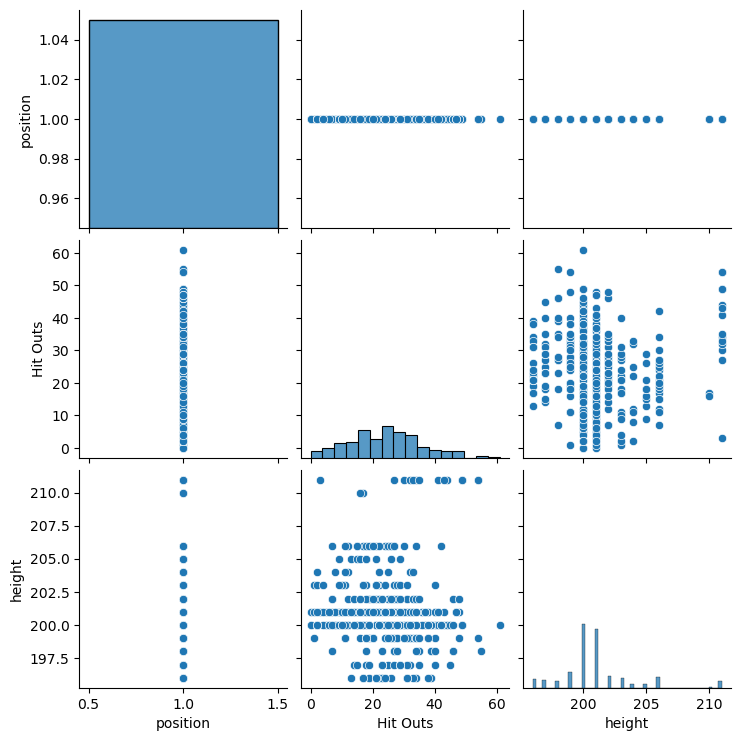

<Figure size 2000x500 with 0 Axes>

In [10]:
data1 = data[(data['year'] == 2012) & (data['position'] == 'Ruck')]
position_map = {'Ruck': 1, 'Defender': 0, 'Forward': 0, 'Midfield': 0, 'Midfield, Forward': 0, 'Defender, Midfield': 0, 'Defender, Forward': 0, 'Forward, Ruck': 0, 'Defender, Ruck': 0, 'Midfield, Ruck': 0}
data1['position'] = data1['position'].replace(position_map)
pairplot_variables = ['position', 'Hit Outs', 'height']
data1 = data1.loc[:, pairplot_variables]
sns.pairplot(data=data1)
plt.figure(figsize=(20, 5))
plt.show()


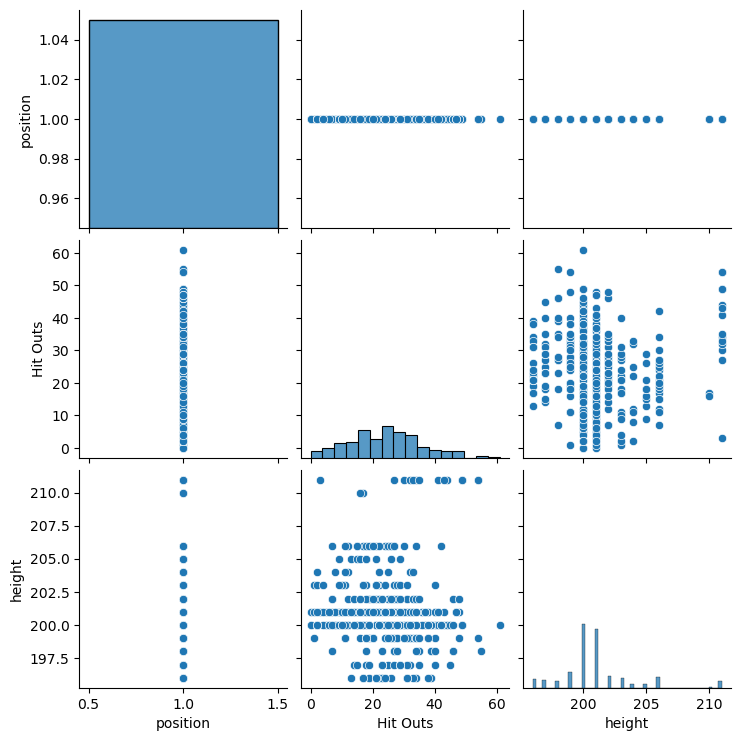

<Figure size 2000x500 with 0 Axes>

In [11]:
pairplot_variables = ['position', 'Hit Outs', 'height']
data1 = data1.loc[:, pairplot_variables]
sns.pairplot(data=data1)
plt.figure(figsize=(20, 5))
plt.show()

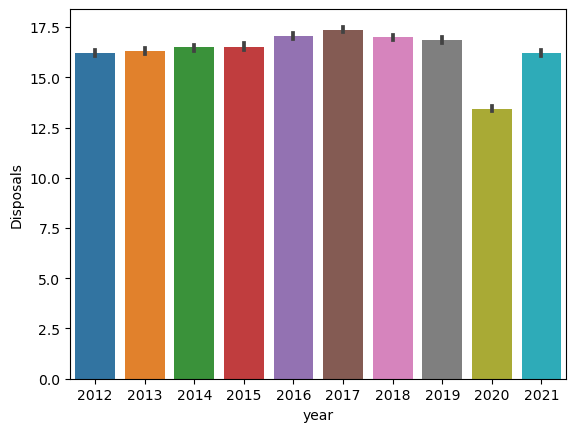

In [12]:
sns.barplot(x='year',y='Disposals',data = data_pivot)
plt.show()

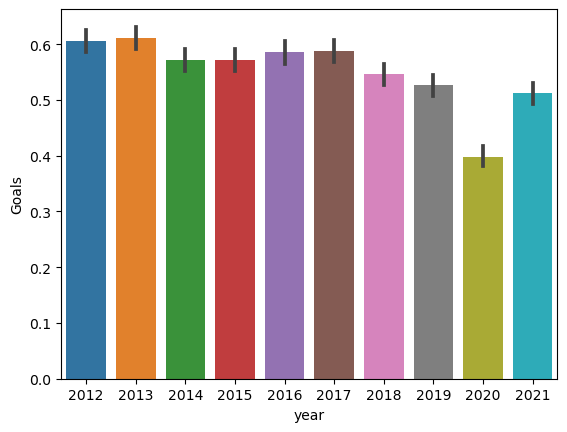

In [13]:
sns.barplot(x='year',y='Goals',data = data_pivot)
plt.show()

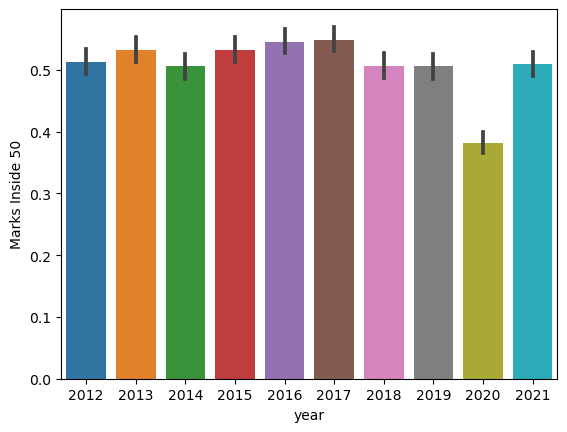

In [14]:
sns.barplot(x='year',y='Marks Inside 50',data = data_pivot)
plt.show()

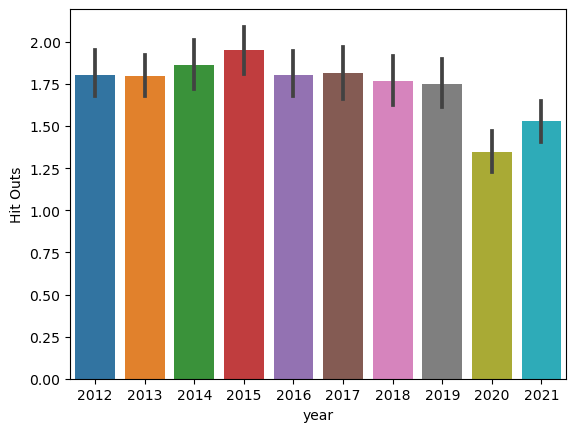

In [15]:
sns.barplot(x='year',y='Hit Outs',data = data_pivot)
plt.show()

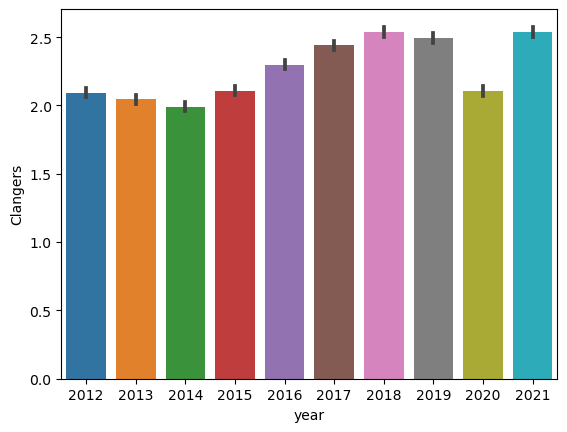

In [16]:
sns.barplot(x='year',y='Clangers',data = data_pivot)
plt.show()

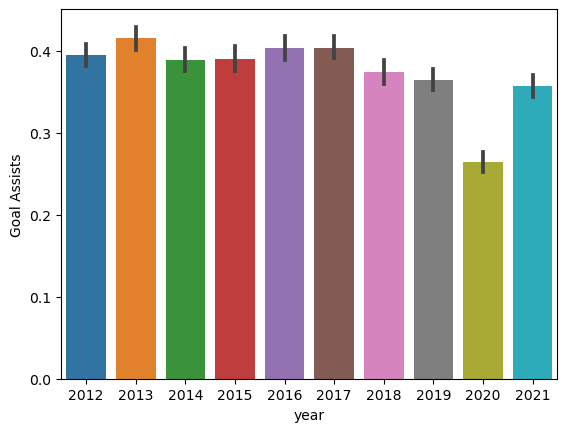

In [17]:
sns.barplot(x='year',y='Goal Assists',data = data_pivot)
plt.show()

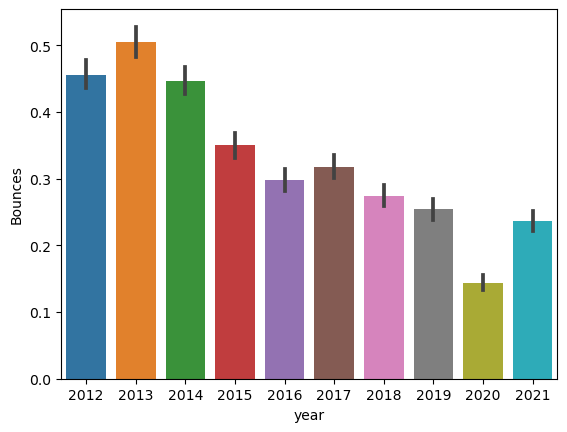

In [18]:
sns.barplot(x='year',y='Bounces',data = data_pivot)
plt.show()

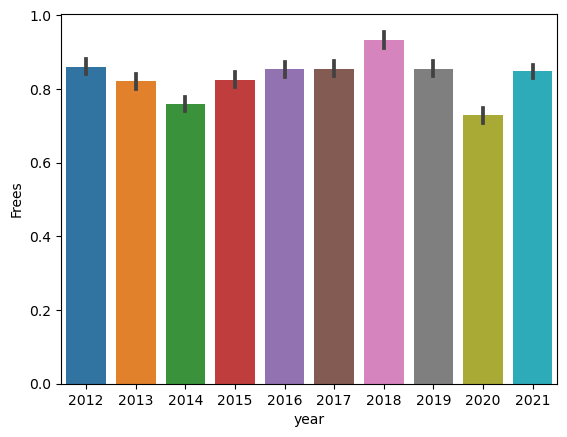

In [19]:
sns.barplot(x='year',y='Frees',data = data_pivot)
plt.show()

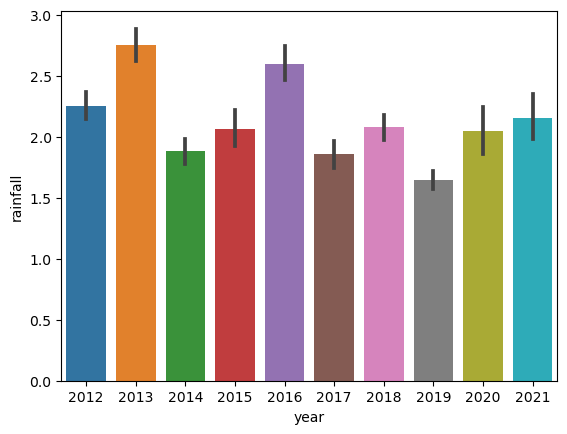

In [20]:
sns.barplot(x='year',y='rainfall',data = data_pivot)
plt.show()

## Further manipulation of data

In [21]:
# Further groups the data, doing this by summing every relevant metric together for each team.
data_pivot_games_metrics = data.pivot_table(index = ['gameId', 'team'], aggfunc = np.sum)[
    ['Behinds', 'Bounces', 'Brownlow Votes', 'Clangers',
       'Clearances', 'Contested Marks', 'Contested Possessions', 'Disposals',
       'Frees', 'Frees Against', 'Goal Assists', 'Goals', 'Handballs',
       'Hit Outs', 'Inside 50s', 'Kicks', 'Marks', 'Marks Inside 50',
       'One Percenters', 'Rebounds', 'Tackles', 'Uncontested Possessions',]
].reset_index()

# Calculates the mean age for each team at each game.
data_pivot_games_avg = data.pivot_table(index = ['gameId', 'team'], aggfunc = np.mean)[['age', 'height', 'weight']]

# Merges the two dataframes above into one overall dataset for each game.
data_pivot_games = pd.merge(data_pivot_games_metrics, data_pivot_games_avg.reset_index())
data_pivot_games

gameId                    team  Behinds  Bounces  Brownlow Votes  \
0     2012EF01               Fremantle        8        3               0   
1     2012EF01                 Geelong       11        2               0   
2     2012EF02         North Melbourne       10       21               0   
3     2012EF02              West Coast       13       25               0   
4     2012GF01                Hawthorn       13       11               0   
...        ...                     ...      ...      ...             ...   
4043  2021R909              West Coast        9        7               5   
4044  2021SF01                 Geelong       10        5               0   
4045  2021SF01  Greater Western Sydney        6        6               0   
4046  2021SF02          Brisbane Lions       10        4               0   
4047  2021SF02        Western Bulldogs       11        9               0   

      Clangers  Clearances  Contested Marks  Contested Possessions  Disposals  \
0           53          34               14                    148        325   
1           39          38                6                    158        321   
2           42          42                7                    139        289   
3           49          43               17                    142        358   
4           42          58               14                    170        336   
...        ...         ...              ...                    ...        ...   
4043        45          32               18                    132        389   
4044        42          41               12                    141        355   
4045        57          43                8                    135        325   
4046        69          37                7                    145        351   
4047        59          47                8                    155        352   

      ...  Kicks  Marks  Marks Inside 50  One Percenters  Rebounds  Tackles  \
0     ...    211     94               22              64        35       77   
1     ...    182     52               10              60        25       86   
2     ...    170     57                8              39        41       36   
3     ...    231    112               17              53        28       38   
4     ...    194     56               10              66        26       84   
...   ...    ...    ...              ...             ...       ...      ...   
4043  ...    241    127               18              40        45       50   
4044  ...    223     92               13              61        38       59   
4045  ...    185     65                5              57        34       68   
4046  ...    211     79               12              70        41       67   
4047  ...    223     65                6              67        57       64   

      Uncontested Possessions        age      height     weight  
0                         173  25.363636  188.818182  89.636364  
1                         164  26.272727  188.181818  89.090909  
2                         157  24.590909  187.454545  87.590909  
3                         218  25.090909  189.045455  90.909091  
4                         171  24.909091  187.454545  88.090909  
...                       ...        ...         ...        ...  
4043                      256  26.227273  189.772727  89.136364  
4044                      221  27.695652  189.130435  88.826087  
4045                      198  25.130435  188.347826  85.695652  
4046                      208  26.173913  188.391304  88.217391  
4047                      189  25.521739  187.304348  85.043478  

[4048 rows x 27 columns]

In [22]:
# Merges the game-grouped data_pivot_games dataset with the corresponding game statistics from the original
# dataset.
data_games = pd.merge(data_pivot_games, data[['gameId', 'homeTeam', 'awayTeam', 'homeTeamScore', 'awayTeamScore', 'year']])
data_games = data_games.drop_duplicates(ignore_index = True)

# Creates a column using the game statistics appended before that shows whether or not the team displayed won
# the corresponding game.
data_games['win'] = np.where(
    data_games['team'] == data_games['homeTeam'],
    np.where(
        data_games['homeTeamScore'] > data_games['awayTeamScore'],
        1, 0
    ),
    np.where(
        data_games['homeTeamScore'] < data_games['awayTeamScore'],
        1, 0
    )
    
)
data_games

gameId                    team  Behinds  Bounces  Brownlow Votes  \
0     2012EF01               Fremantle        8        3               0   
1     2012EF01                 Geelong       11        2               0   
2     2012EF02         North Melbourne       10       21               0   
3     2012EF02              West Coast       13       25               0   
4     2012GF01                Hawthorn       13       11               0   
...        ...                     ...      ...      ...             ...   
4043  2021R909              West Coast        9        7               5   
4044  2021SF01                 Geelong       10        5               0   
4045  2021SF01  Greater Western Sydney        6        6               0   
4046  2021SF02          Brisbane Lions       10        4               0   
4047  2021SF02        Western Bulldogs       11        9               0   

      Clangers  Clearances  Contested Marks  Contested Possessions  Disposals  \
0           53          34               14                    148        325   
1           39          38                6                    158        321   
2           42          42                7                    139        289   
3           49          43               17                    142        358   
4           42          58               14                    170        336   
...        ...         ...              ...                    ...        ...   
4043        45          32               18                    132        389   
4044        42          41               12                    141        355   
4045        57          43                8                    135        325   
4046        69          37                7                    145        351   
4047        59          47                8                    155        352   

      ...  Uncontested Possessions        age      height     weight  \
0     ...                      173  25.363636  188.818182  89.636364   
1     ...                      164  26.272727  188.181818  89.090909   
2     ...                      157  24.590909  187.454545  87.590909   
3     ...                      218  25.090909  189.045455  90.909091   
4     ...                      171  24.909091  187.454545  88.090909   
...   ...                      ...        ...         ...        ...   
4043  ...                      256  26.227273  189.772727  89.136364   
4044  ...                      221  27.695652  189.130435  88.826087   
4045  ...                      198  25.130435  188.347826  85.695652   
4046  ...                      208  26.173913  188.391304  88.217391   
4047  ...                      189  25.521739  187.304348  85.043478   

            homeTeam                awayTeam  homeTeamScore  awayTeamScore  \
0            Geelong               Fremantle             80             96   
1            Geelong               Fremantle             80             96   
2         West Coast         North Melbourne            162             66   
3         West Coast         North Melbourne            162             66   
4           Hawthorn                  Sydney             81             91   
...              ...                     ...            ...            ...   
4043      West Coast                Adelaide            106             76   
4044         Geelong  Greater Western Sydney            103             68   
4045         Geelong  Greater Western Sydney            103             68   
4046  Brisbane Lions        Western Bulldogs             78             79   
4047  Brisbane Lions        Western Bulldogs             78             79   

      year  win  
0     2012    1  
1     2012    0  
2     2012    0  
3     2012    1  
4     2012    0  
...    ...  ...  
4043  2021    1  
4044  2021    1  
4045  2021    0  
4046  2021    0  
4047  2021    1  

[4048 rows x 33 columns]

In [23]:
print(data_games.columns)
# Finds the average for every metric in the dataset for each game's metrics, doing this across the entire 2012-2021
# time period.
data_games.groupby(by = 'team').mean().drop('year', axis = 1)

Index(['gameId', 'team', 'Behinds', 'Bounces', 'Brownlow Votes', 'Clangers',
       'Clearances', 'Contested Marks', 'Contested Possessions', 'Disposals',
       'Frees', 'Frees Against', 'Goal Assists', 'Goals', 'Handballs',
       'Hit Outs', 'Inside 50s', 'Kicks', 'Marks', 'Marks Inside 50',
       'One Percenters', 'Rebounds', 'Tackles', 'Uncontested Possessions',
       'age', 'height', 'weight', 'homeTeam', 'awayTeam', 'homeTeamScore',
       'awayTeamScore', 'year', 'win'],
      dtype='object')


Behinds   Bounces  Brownlow Votes   Clangers  \
team                                                                    
Adelaide                9.625000  6.446429        2.968750  48.857143   
Brisbane Lions          8.583710  4.606335        2.461538  50.873303   
Carlton                 8.456221  8.792627        2.470046  49.788018   
Collingwood             8.726872  7.612335        3.167401  49.916300   
Essendon                8.894977  7.634703        2.675799  50.214612   
Fremantle               8.151786  5.535714        3.053571  49.129464   
Geelong                 9.250000  5.377119        3.411017  49.669492   
Gold Coast              8.330233  8.702326        1.981395  52.283721   
Greater Western Sydney  8.592105  9.276316        2.644737  52.109649   
Hawthorn                9.000000  6.814655        3.146552  47.728448   
Melbourne               8.425339  5.832579        2.547511  51.755656   
North Melbourne         8.704036  8.663677        2.659193  49.372197   
Port Adelaide           9.337778  7.720000        3.124444  52.680000   
Richmond                8.952174  8.991304        3.091304  52.491304   
St Kilda                9.032258  9.345622        2.506912  50.041475   
Sydney                  8.888889  5.880342        3.508547  50.747863   
West Coast              8.685590  7.017467        3.205240  46.414847   
Western Bulldogs        8.964602  7.730088        2.818584  47.008850   

                        Clearances  Contested Marks  Contested Possessions  \
team                                                                         
Adelaide                 37.531250        11.526786             145.178571   
Brisbane Lions           37.466063         9.773756             134.493213   
Carlton                  36.815668        10.903226             135.760369   
Collingwood              35.696035        11.070485             141.083700   
Essendon                 35.429224        11.091324             135.826484   
Fremantle                36.750000        10.955357             139.133929   
Geelong                  36.381356        12.008475             141.572034   
Gold Coast               36.390698         9.562791             136.427907   
Greater Western Sydney   38.381579         9.921053             137.175439   
Hawthorn                 36.840517        10.366379             136.435345   
Melbourne                35.981900        11.248869             141.158371   
North Melbourne          36.331839        10.838565             137.246637   
Port Adelaide            38.635556        10.737778             142.968889   
Richmond                 34.756522        10.626087             137.082609   
St Kilda                 34.976959        10.649770             132.834101   
Sydney                   37.380342        11.307692             145.534188   
West Coast               37.624454        12.384279             137.572052   
Western Bulldogs         37.738938        10.296460             141.584071   

                         Disposals      Frees  Frees Against  ...  \
team                                                          ...   
Adelaide                366.312500  18.517857      17.361607  ...   
Brisbane Lions          346.502262  19.217195      19.733032  ...   
Carlton                 345.341014  18.645161      18.175115  ...   
Collingwood             376.039648  18.145374      16.515419  ...   
Essendon                370.534247  17.634703      18.155251  ...   
Fremantle               359.500000  17.656250      18.397321  ...   
Geelong                 366.398305  18.822034      18.953390  ...   
Gold Coast              344.204651  17.734884      18.237209  ...   
Greater Western Sydney  361.407895  18.267544      19.614035  ...   
Hawthorn                374.034483  17.857759      18.202586  ...   
Melbourne               356.968326  18.447964      18.968326  ...   
North Melbourne         360.255605  19.623318      18.058296  ...   
Port Adelaide           365.026667  1

In [24]:
# Averages the statistics per game across each year for every team.
data_games_avg = data_games.pivot_table(index = ['team', 'year'], aggfunc = np.mean).reset_index()
data_games_avg

team  year    Behinds    Bounces  Brownlow Votes   Clangers  \
0            Adelaide  2012  10.600000   6.760000        3.520000  43.840000   
1            Adelaide  2013  10.227273   9.727273        2.954545  43.545455   
2            Adelaide  2014  10.227273  11.545455        3.227273  42.181818   
3            Adelaide  2015   9.347826   6.391304        3.173913  49.347826   
4            Adelaide  2016  11.291667   6.541667        3.625000  50.041667   
..                ...   ...        ...        ...             ...        ...   
175  Western Bulldogs  2017  10.909091   7.136364        2.318182  47.318182   
176  Western Bulldogs  2018   8.636364   7.636364        2.136364  52.500000   
177  Western Bulldogs  2019  10.173913   6.565217        3.521739  50.347826   
178  Western Bulldogs  2020   7.111111   3.777778        3.388889  41.111111   
179  Western Bulldogs  2021   9.153846   7.653846        3.269231  53.692308   

     Clearances  Contested Marks  Contested Possessions   Disposals  ...  \
0     40.240000        12.720000             148.520000  350.560000  ...   
1     36.863636        10.590909             144.727273  367.818182  ...   
2     39.181818        11.227273             144.954545  366.818182  ...   
3     40.608696        11.043478             142.695652  359.608696  ...   
4     38.458333        12.916667             152.250000  391.541667  ...   
..          ...              ...                    ...         ...  ...   
175   34.727273         9.590909             143.954545  392.500000  ...   
176   36.454545         9.454545             139.454545  387.590909  ...   
177   36.913043        10.260870             141.043478  390.217391  ...   
178   29.611111         8.888889             118.000000  309.944444  ...   
179   39.807692        11.692308             143.384615  375.115385  ...   

     One Percenters   Rebounds    Tackles  Uncontested Possessions        age  \
0         47.680000  33.640000  58.320000               199.840000  25.110909   
1         41.909091  33.772727  58.454545               219.590909  24.481405   
2         50.409091  35.272727  62.090909               218.363636  25.002066   
3         42.869565  34.782609  60.173913               214.043478  24.778656   
4         47.500000  33.375000  68.791667               239.791667  25.157197   
..              ...        ...        ...                      ...        ...   
175       47.454545  33.000000  70.454545               246.954545  25.169421   
176       51.500000  36.318182  62.909091               245.954545  23.739669   
177       54.173913  37.565217  62.173913               241.565217  24.586957   
178       44.055556  29.611111  50.222222               190.611111  24.946970   
179       53.615385  36.230769  58.115385               228.846154  25.683262   

     awayTeamScore      height  homeTeamScore     weight       win  
0        94.400000  185.712727      94.200000  87.454545  0.720000  
1        92.409091  186.456612      88.181818  87.466942  0.454545  
2        92.636364  186.365702      92.909091  87.599174  0.500000  
3        85.565217  186.606719     102.913043  87.213439  0.608696  
4        91.958333  187.479167     103.791667  87.867424  0.708333  
..             ...         ...            ...        ...       ...  
175      81.863636  186.950413      89.500000  86.570248  0.500000  
176      78.363636  187.179752      85.818182  85.068182  0.363636  
177      82.347826  187.114625      88.043478  84.693676  0.521739  
178      61.722222  187.224747      64.277778  84.780303  0.555556  
179      79.230769  187.056172      80.000000  84.976209  0.692308  

[180 rows x 30 columns]

In [25]:
# Calculates different statistics for each metric, which can be compared with the linear model below.
data_games_avg.describe().transpose()

count         mean        std          min  \
year                     180.0  2016.500000   2.880293  2012.000000   
Behinds                  180.0     8.739250   1.351362     4.588235   
Bounces                  180.0     7.229970   3.321120     1.411765   
Brownlow Votes           180.0     2.841237   0.747902     0.727273   
Clangers                 180.0    49.980950   5.396220    40.680000   
Clearances               180.0    36.538371   3.227283    25.705882   
Contested Marks          180.0    10.799202   1.452657     7.181818   
Contested Possessions    180.0   138.259521   9.786084   110.058824   
Disposals                180.0   360.211119  27.153163   279.421053   
Frees                    180.0    18.384239   1.721795    13.529412   
Frees Against            180.0    18.352003   1.839085    13.473684   
Goal Assists             180.0     8.236967   1.540601     4.176471   
Goals                    180.0    12.103025   2.108132     6.823529   
Handballs                180.0   154.131834  18.071448    98.157895   
Hit Outs                 180.0    38.356881   6.332609    18.666667   
Inside 50s               180.0    50.331191   4.989502    36.117647   
Kicks                    180.0   206.079285  14.581964   156.529412   
Marks                    180.0    88.205961   9.377802    59.176471   
Marks Inside 50          180.0    11.166135   1.813457     5.705882   
One Percenters           180.0    47.486027   4.669368    36.600000   
Rebounds                 180.0    35.251469   3.324378    27.368421   
Tackles                  180.0    63.168294   6.689240    44.000000   
Uncontested Possessions  180.0   219.646109  21.700133   154.764706   
age                      180.0    25.128539   0.966226    21.654959   
awayTeamScore            180.0    80.829226  10.175739    50.894737   
height                   180.0   187.778028   0.812979   185.510909   
homeTeamScore            180.0    86.990331  10.811318    48.588235   
weight                   180.0    87.490286   1.348783    84.234100   
win                      180.0     0.488120   0.192037     0.045455   

                                 25%          50%          75%          max  
year                     2014.000000  2016.500000  2019.000000  2021.000000  
Behinds                     8.090909     8.701993     9.643043    13.160000  
Bounces                     4.954545     6.595455     9.231225    18.090909  
Brownlow Votes              2.318182     3.000000     3.408696     4.086957  
Clangers                   45.443182    49.310277    54.568182    63.636364  
Clearances                 34.609023    36.866601    38.955909    42.400000  
Contested Marks             9.811553    10.818182    11.863636    14.500000  
Contested Possessions     133.534091   139.333333   144.363636   163.576923  
Disposals                 351.906250   364.953463   376.988636   410.807692  
Frees                      17.261364    18.369318    19.585227    22.400000  
Frees Against              17.054118    18.369318    19.681818    22.727273  
Goal Assists                7.181818     8.500000     9.274545    11.760000  
Goals                      10.420455    12.469900    13.465909    17.400000  
Handballs                 146.386364   156.434545   165.924783   198.384615  
Hit Outs                   34.215909    38.795455    42.820158    58.541667  
Inside 50s                 47.522727    51.022727    53.845000    59.880000  
Kicks                     199.899209   208.562500   216.730237   232.192308  
Marks                      83.636364    89.734190    93.610795   107.409091  
Marks Inside 50             9.863636    11.552727    12.311594    15.120000  
One Percenters             44.154091    47.500000    50.206364    61.909091  
Rebounds                   32.897083    35.272727    37.402273    44.318182  
Tackles                    59.479167    63.652500    68.728147    78.769231  
Uncontested Possessions   209.079545   222.170909   232.147727   261.538462  
age                   

## Linear modelling and analysis

In [26]:
# Defines the independent variables as every relevant metric except 'Disposals', which is already related to 
# kicks and handballs, and so is unnecessary.
X = data_games_avg.drop([
    'team', 'win', 'year',
    'homeTeamScore', 'awayTeamScore', 'Disposals'],
    axis = 1
)

# Defines the dependent variable.
y = data_games_avg['win']

# Splits the data above into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size = 0.95,
    random_state = 11
)

linear_model = LinearRegression(fit_intercept = True).fit(X_train, y_train)

# Prints every coefficient in the linear regression model.
# Each coefficient is calculated assuming the win percentage is in terms of 0 to 100 instead of 0 to 1.
a = 0
for i in X.columns:
    print(X.columns[a] + ': ' + str(linear_model.coef_[a]*100) + ' %')
    a += 1

# Prints the training and testing scores of the model.
print('----------------')
print('Training score: ' + str(linear_model.score(X_train, y_train)))
print('Testing score: ' + str(r2_score(y_test, linear_model.predict(X_test))))

Behinds: -0.7105058484613913 %
Bounces: -0.4866191691505618 %
Brownlow Votes: 15.148114089961007 %
Clangers: -0.17870770059166774 %
Clearances: -0.1431220863869678 %
Contested Marks: -0.2171692966863465 %
Contested Possessions: -0.10021244797464351 %
Frees: -0.13489361971065394 %
Frees Against: 0.4132498521811888 %
Goal Assists: -0.9654749242865891 %
Goals: 2.5608399627096667 %
Handballs: -0.17159408157192926 %
Hit Outs: -0.2171071837150127 %
Inside 50s: 0.8359348798287952 %
Kicks: 0.08513854041485013 %
Marks: -0.246718810386544 %
Marks Inside 50: 0.2910583464244298 %
One Percenters: -0.04356882291257409 %
Rebounds: -0.09690318832821372 %
Tackles: 0.03157050683393298 %
Uncontested Possessions: 0.07060238015601138 %
age: 3.1387419586722443 %
height: -1.492561544483716 %
weight: 1.0478139108096145 %
----------------
Training score: 0.8525999182534303
Testing score: 0.8819296149099952


In [27]:
# Calculates the average of each player/action metric for each position, grouping these by team and year.
data_games_pos_metrics = data.pivot_table(
    index = ['year', 'team', 'position'],
    aggfunc = np.mean
).reset_index().drop(
    ['playerId', 'homeTeamScore', 'awayTeamScore',
     'attendance', 'gameNumber', 'rainfall', '% Played'],
    axis = 1
)

# Calculates the weighted values of each position via the grouped position data from before and the linear
# model coefficients for each metric.
pos_value_weighted = data_games_pos_metrics.drop(
    ['year', 'team', 'position', 'Disposals'],
    axis = 1
)*linear_model.coef_

# Merges the weighted value dataframe with the corresponding year, team, and position.
pos_values = pd.concat(
    [data_games_pos_metrics[['year', 'team', 'position']],
     np.sum(pos_value_weighted.transpose())],
    axis = 1)

# Groups the value of each position, finding the average value when considering every single team.
pos_values_grouped = pos_values.groupby(by = ['year', 'position']).mean().reset_index().sort_values(
    by = 0,
    ascending = False
)

pos_values_grouped

year           position         0
8   2012     Midfield, Ruck -0.880482
85  2021     Defender, Ruck -0.959061
76  2020     Defender, Ruck -0.976531
88  2021           Midfield -1.014562
62  2018  Midfield, Forward -1.015759
..   ...                ...       ...
42  2016      Forward, Ruck -1.187622
78  2020      Forward, Ruck -1.188746
22  2014     Defender, Ruck -1.196740
13  2013     Defender, Ruck -1.217882
3   2012     Defender, Ruck -1.262637

[91 rows x 3 columns]

In [28]:
years = [
    2012, 2013, 2014, 2015,
    2016, 2017, 2018, 2019,
    2020, 2021
]
a = 0
# Prints the value of each position for every year.
for i in years:
    print(pos_values_grouped[pos_values_grouped['year'] == years[a]])
    a += 1

   year            position         0
8  2012      Midfield, Ruck -0.880482
4  2012             Forward -1.050003
6  2012            Midfield -1.060989
7  2012   Midfield, Forward -1.097148
1  2012   Defender, Forward -1.097962
0  2012            Defender -1.100761
2  2012  Defender, Midfield -1.119980
5  2012       Forward, Ruck -1.147323
9  2012                Ruck -1.153996
3  2012      Defender, Ruck -1.262637
    year            position         0
14  2013             Forward -1.037699
16  2013            Midfield -1.067933
11  2013   Defender, Forward -1.073992
17  2013   Midfield, Forward -1.081805
10  2013            Defender -1.093501
12  2013  Defender, Midfield -1.115208
15  2013       Forward, Ruck -1.132485
18  2013                Ruck -1.171364
13  2013      Defender, Ruck -1.217882
    year            position         0
23  2014             Forward -1.035713
25  2014            Midfield -1.065787
26  2014   Midfield, Forward -1.070156
19  2014            Defender -1.0842

## Additional pairplot analysis and graphs

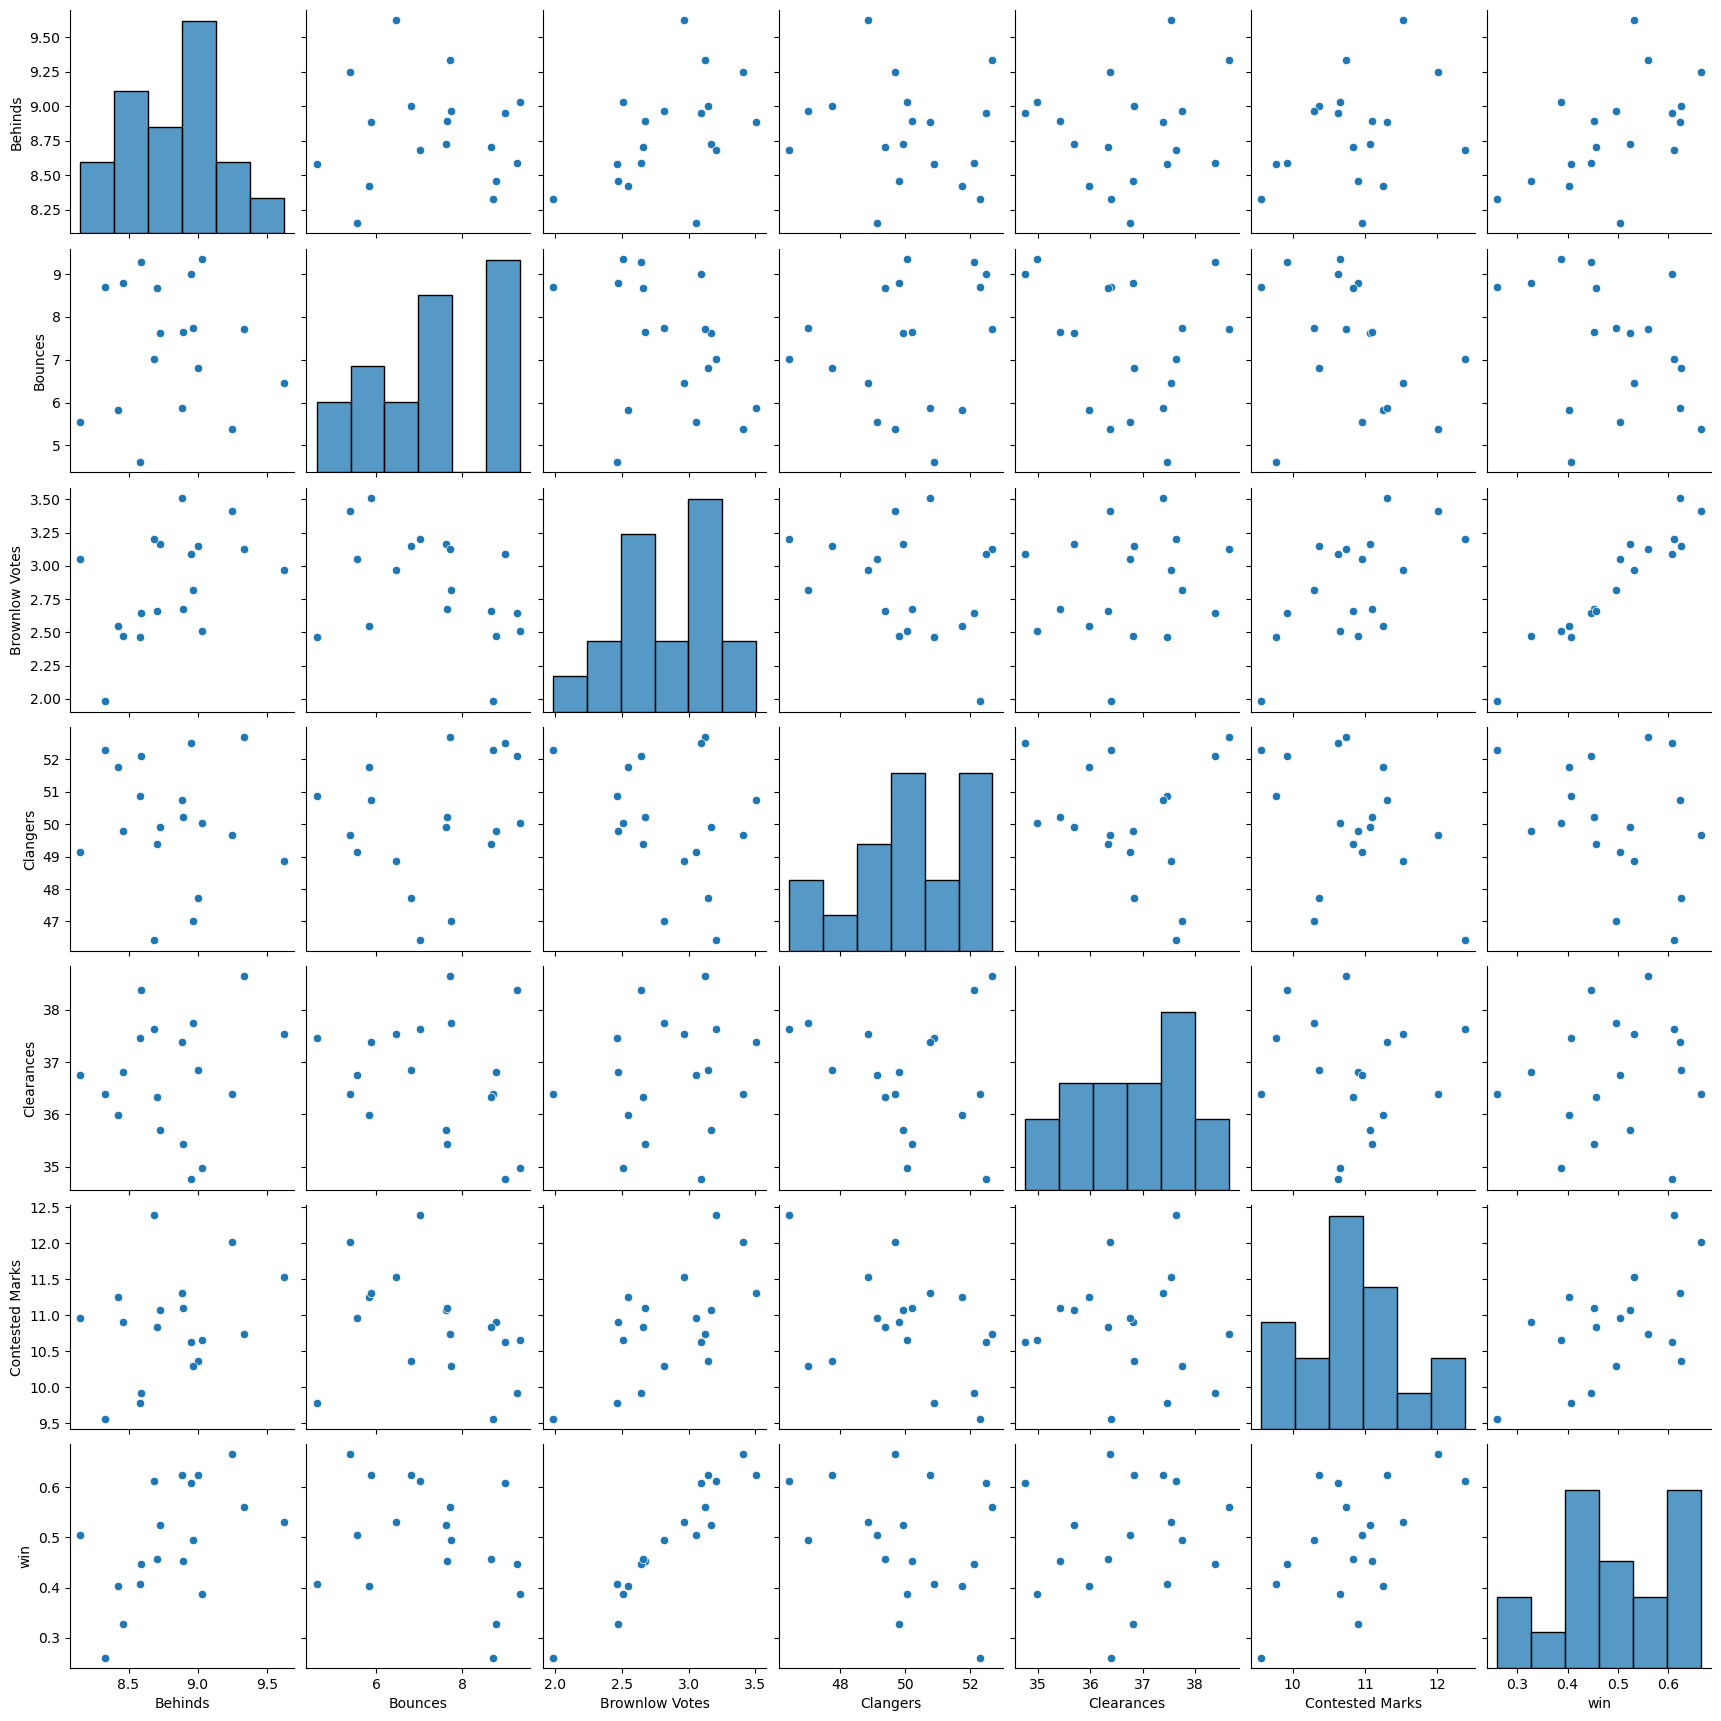

In [29]:
# Finds the average for each metric.
data_metrics_mean = data_games.groupby(by = 'team').mean()

# Select the variables for pairplot
variables = ['Behinds', 'Bounces', 'Brownlow Votes', 'Clangers', 'Clearances',
             'Contested Marks', 'win']

# Create a subset dataframe with the selected variables
subset_data = data_metrics_mean[variables]

# Create pairplot
sns.pairplot(subset_data)
plt.show()

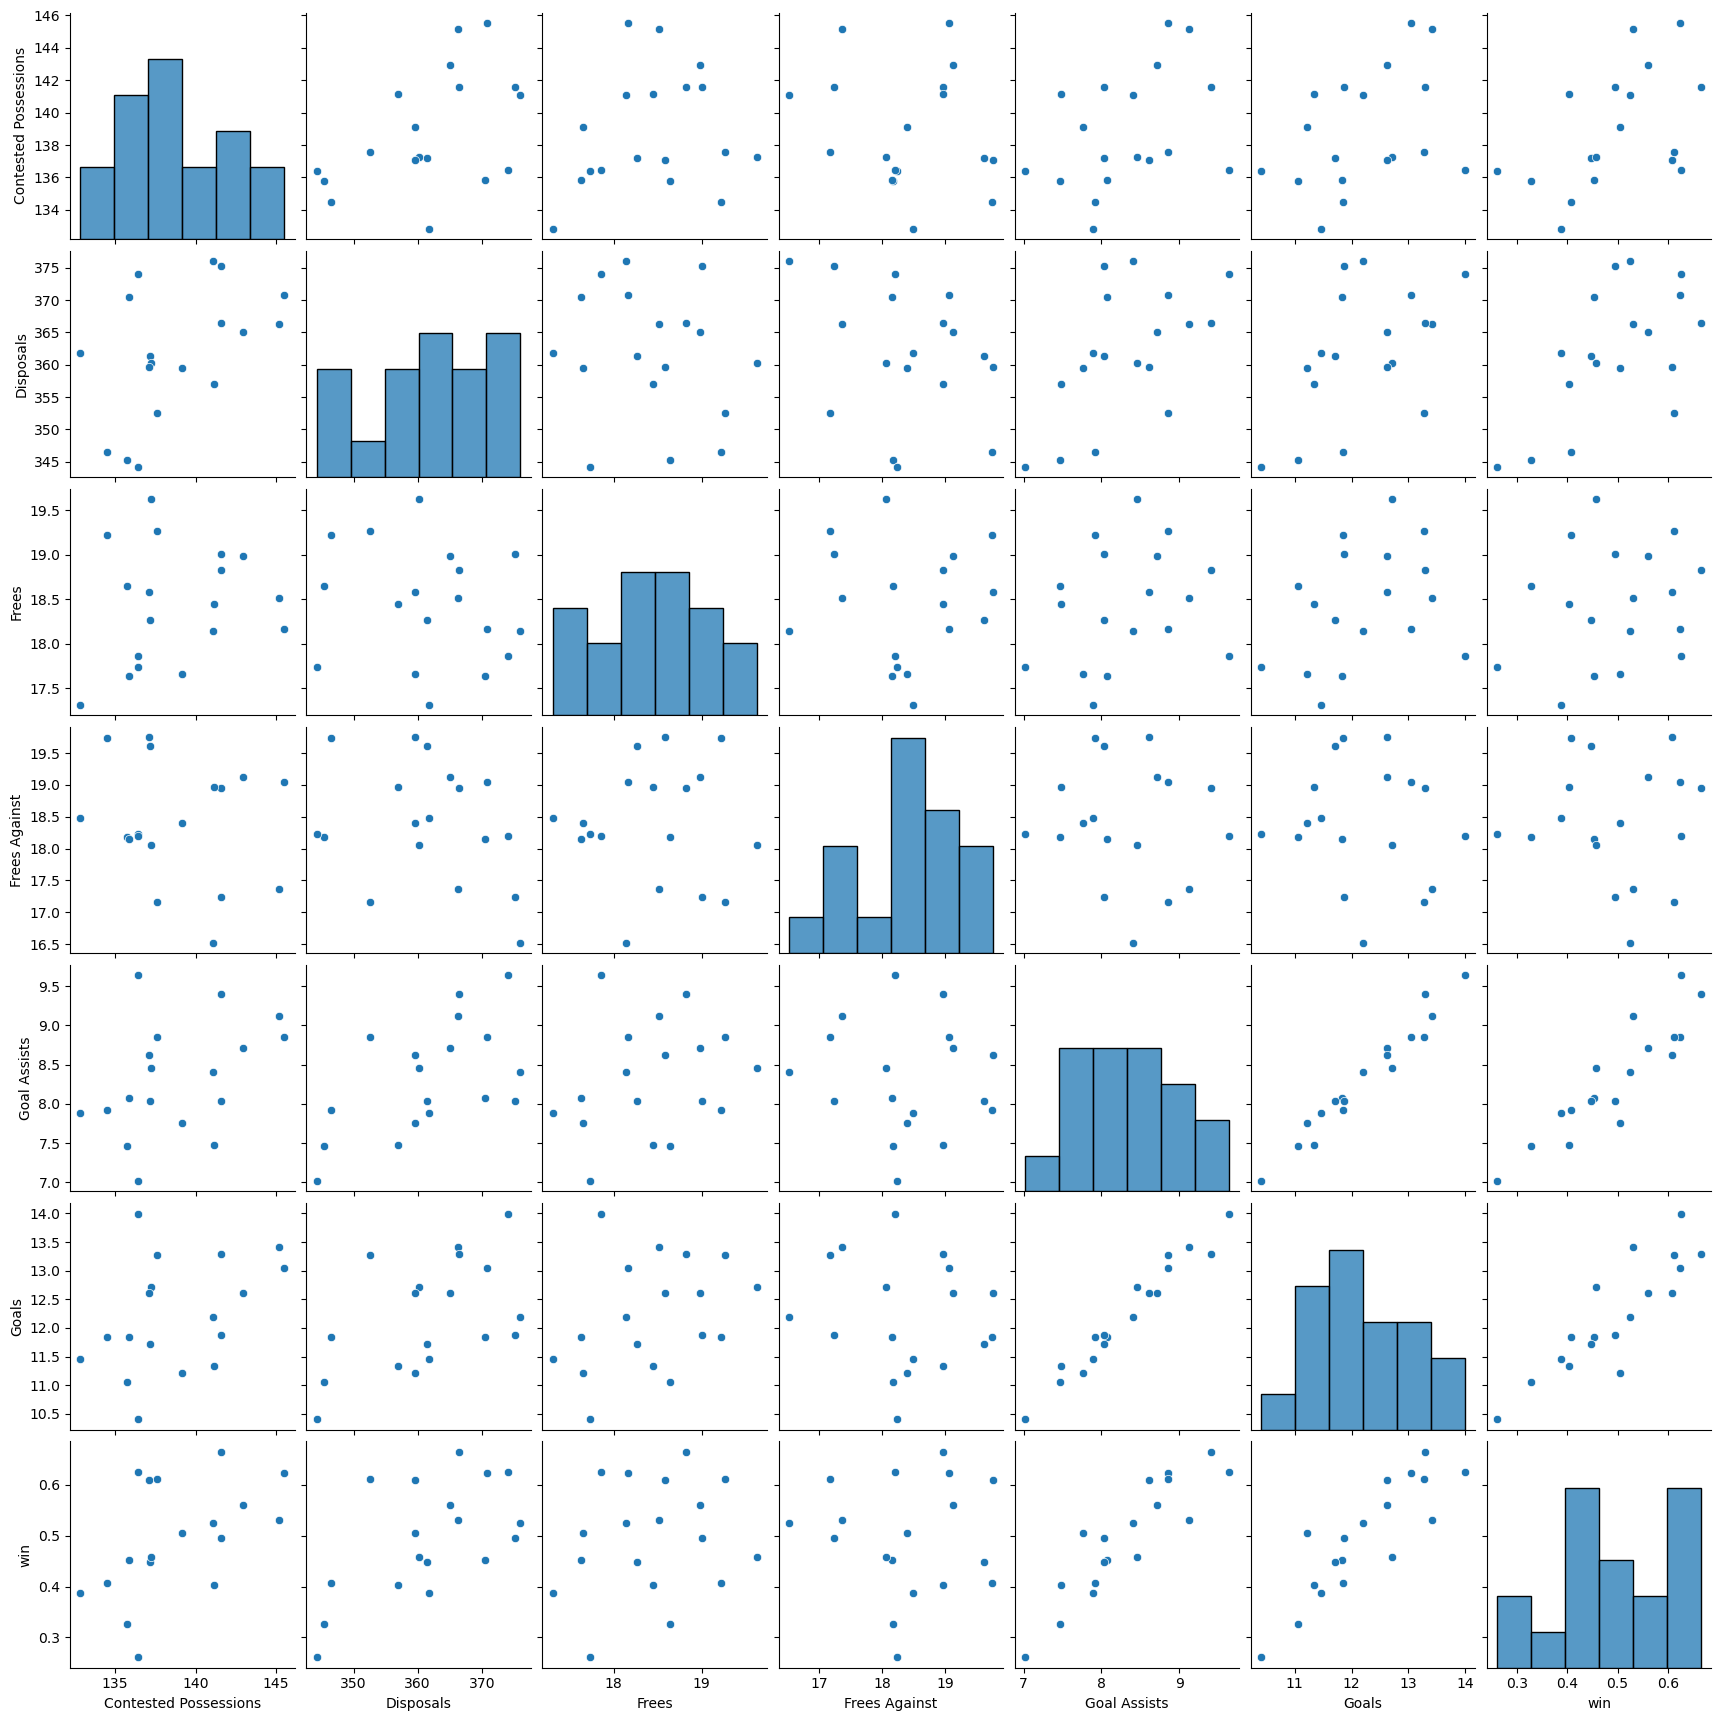

In [30]:
# Finds the average for each metric.
data_metrics_mean = data_games.groupby(by = 'team').mean()

# Select the variables for pairplot
variables = ['Contested Possessions', 'Disposals', 'Frees',
             'Frees Against', 'Goal Assists', 'Goals','win']

# Create a subset dataframe with the selected variables
subset_data = data_metrics_mean[variables]

# Create pairplot
sns.pairplot(subset_data)
plt.show()

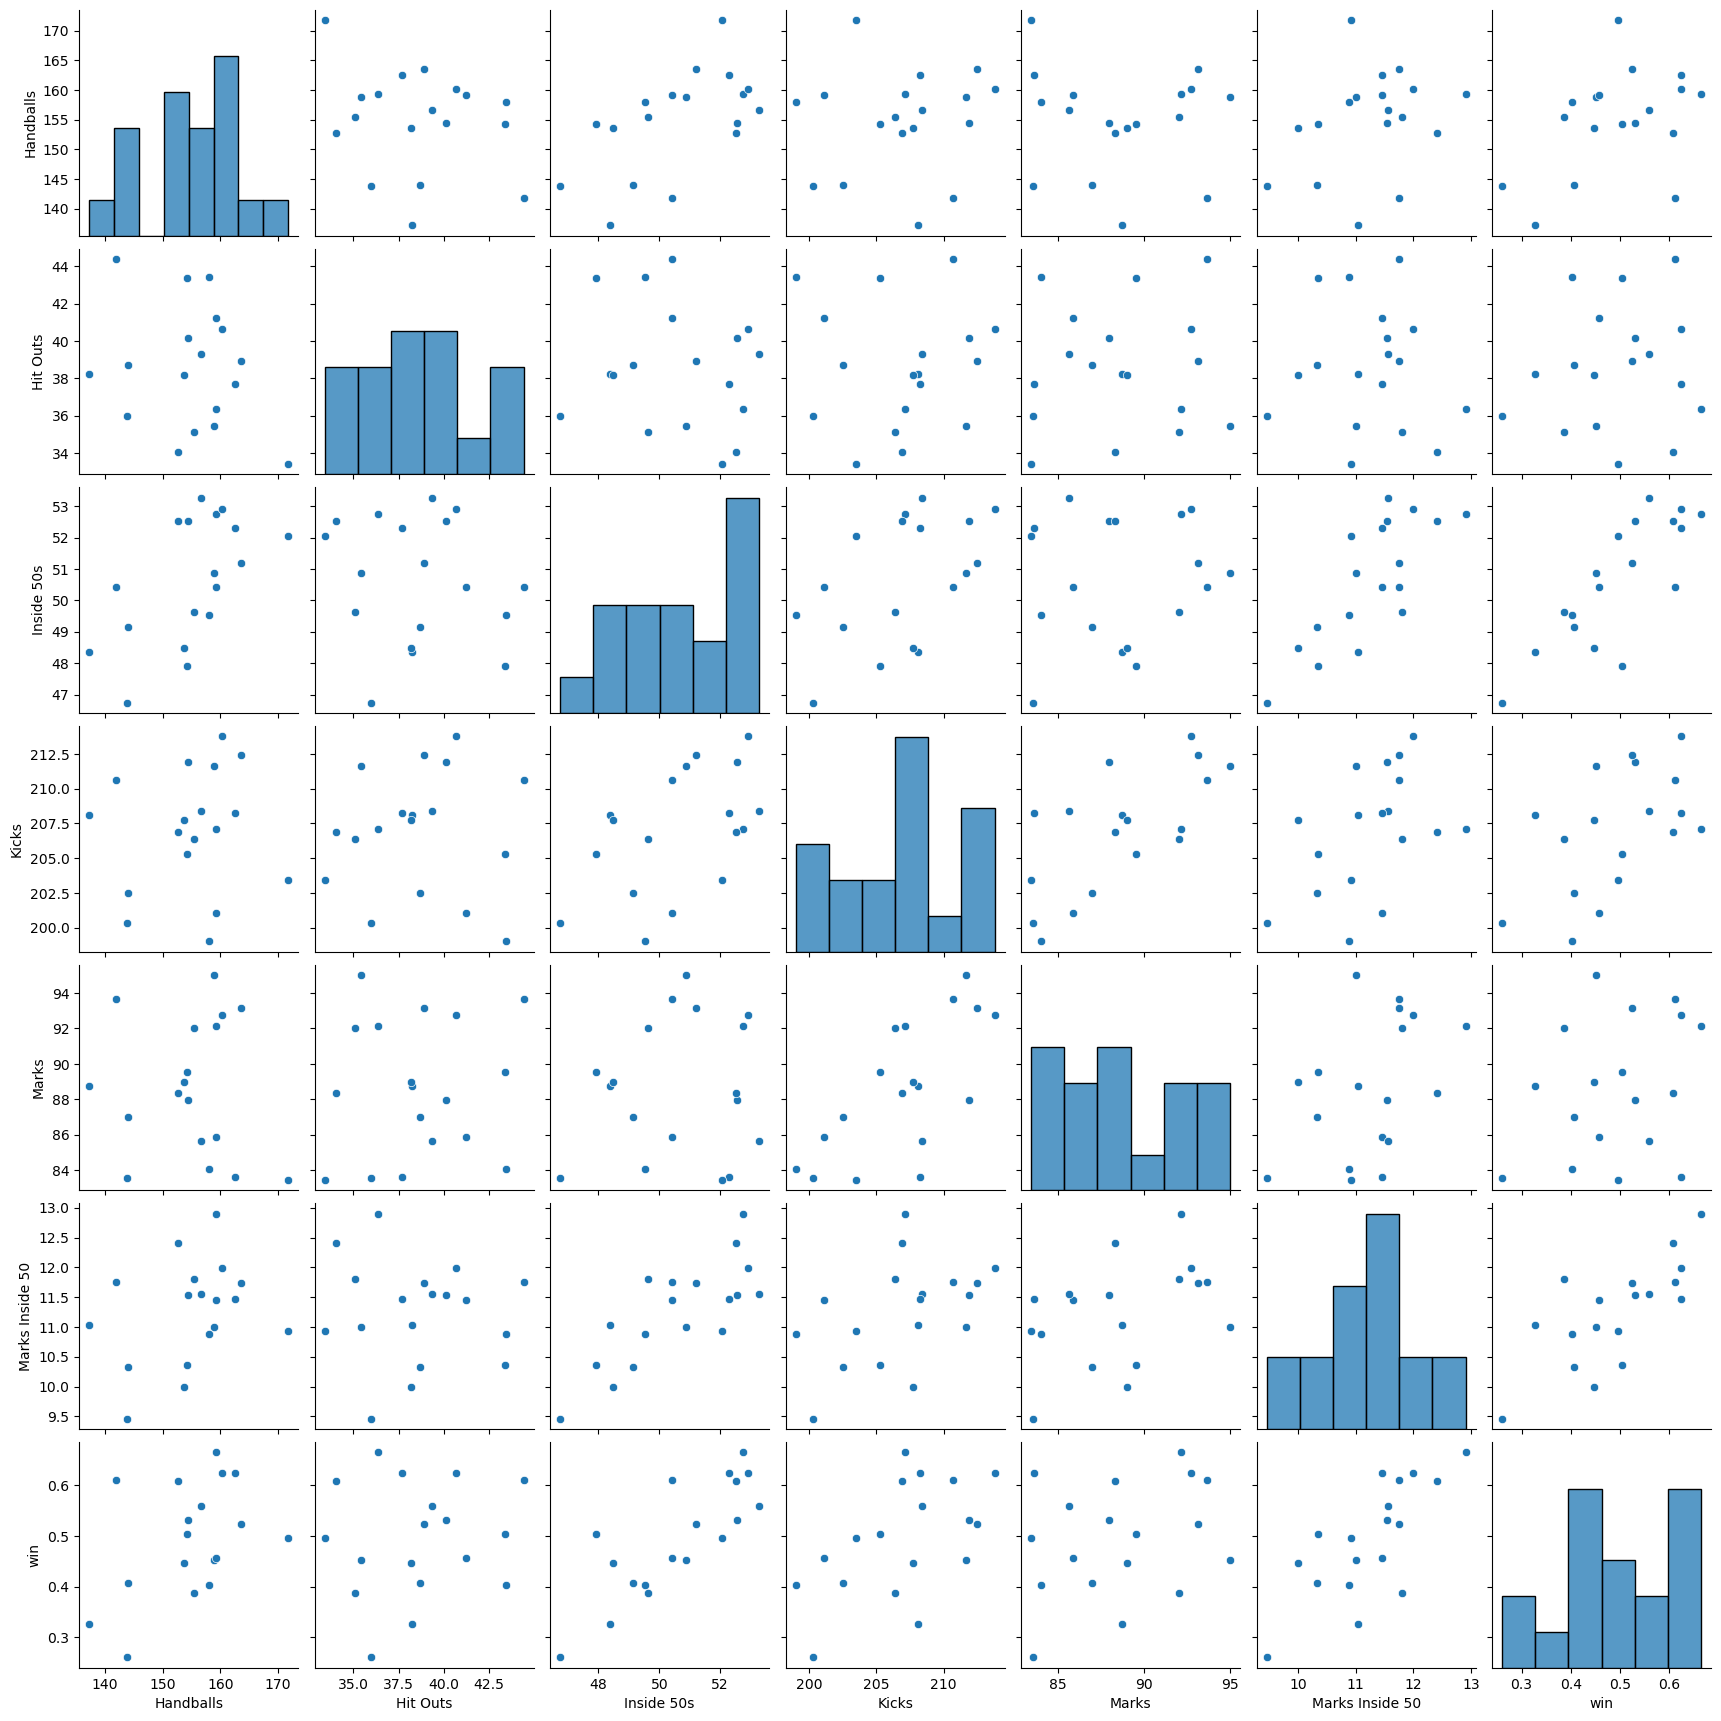

In [31]:
# Finds the average for each metric.
data_metrics_mean = data_games.groupby(by = 'team').mean()

# Select the variables for pairplot
variables = ['Handballs', 'Hit Outs',
             'Inside 50s', 'Kicks', 'Marks', 'Marks Inside 50','win']

# Create a subset dataframe with the selected variables
subset_data = data_metrics_mean[variables]

# Create pairplot
sns.pairplot(subset_data)
plt.show()

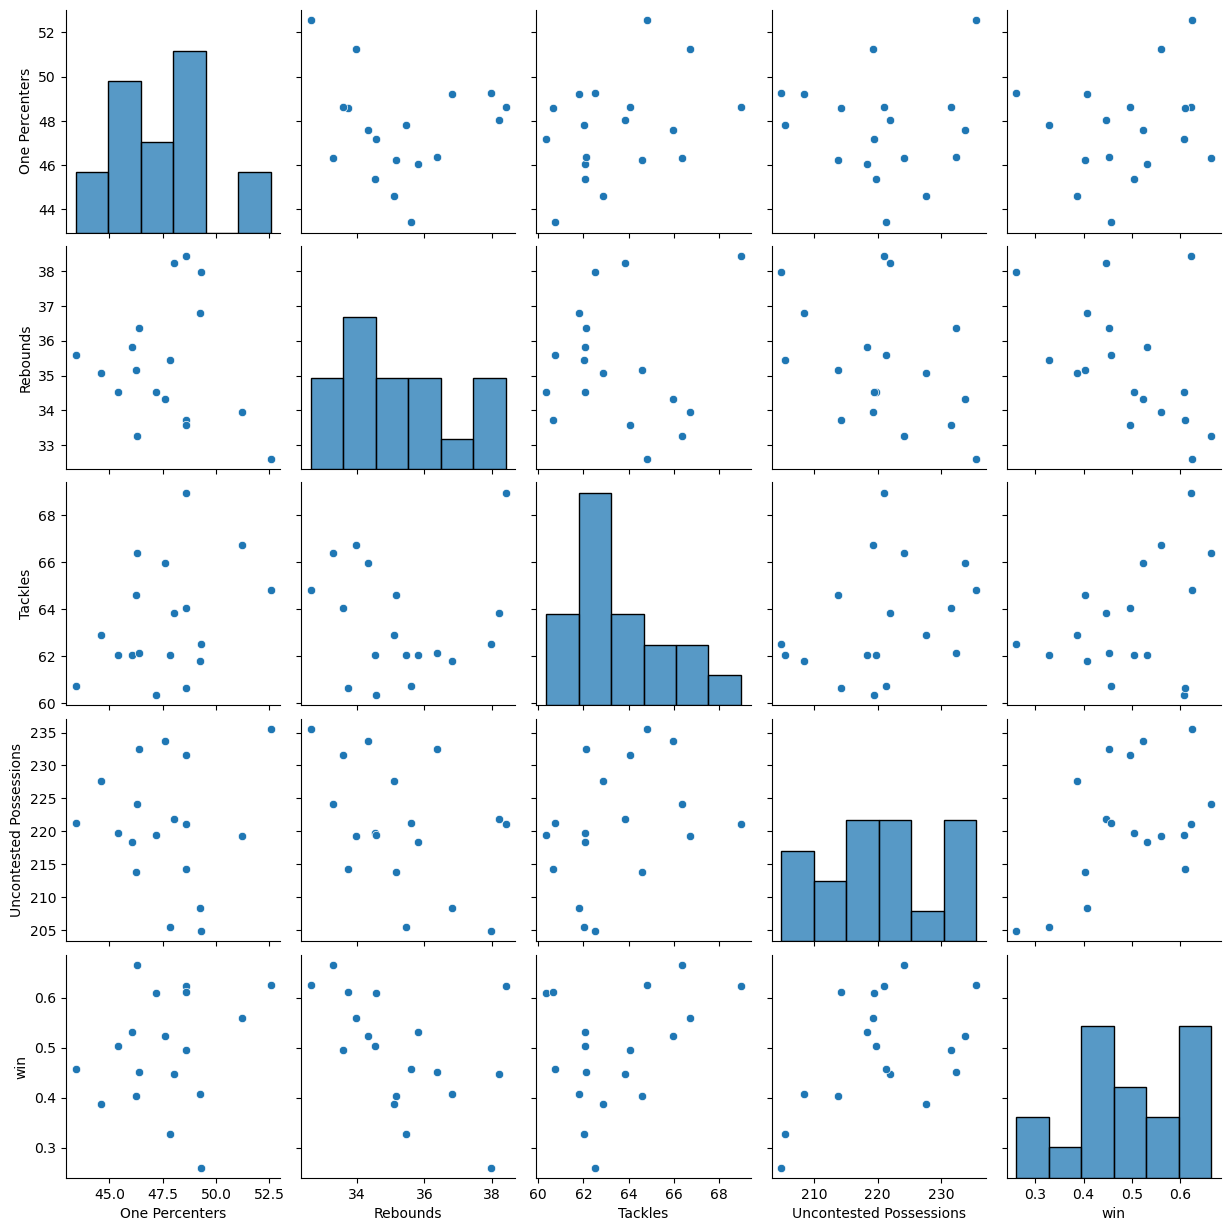

In [32]:
# Finds the average for each metric.
data_metrics_mean = data_games.groupby(by = 'team').mean()

# Select the variables for pairplot
variables = ['One Percenters',
             'Rebounds', 'Tackles', 'Uncontested Possessions', 'win']

# Create a subset dataframe with the selected variables
subset_data = data_metrics_mean[variables]

# Create pairplot
sns.pairplot(subset_data)
plt.show()

In [41]:
# Creates a dataframe that shows the overall win percentage of each team per year.
data_games_win = (pd.DataFrame(data_games.groupby(by = ['team', 'year']).mean()['win'])*100).reset_index()

## Input a team out of this list:
## 'Fremantle', 'Geelong', 'North Melbourne', 'West Coast',
## 'Hawthorn', 'Sydney', 'Collingwood', 'Adelaide', 'Richmond',
## 'St Kilda', 'Greater Western Sydney', 'Carlton', 'Port Adelaide',
## 'Essendon', 'Melbourne', 'Brisbane Lions', 'Western Bulldogs',
## 'Gold Coast'
data_games_win

team  year        win
0            Adelaide  2012  72.000000
1            Adelaide  2013  45.454545
2            Adelaide  2014  50.000000
3            Adelaide  2015  60.869565
4            Adelaide  2016  70.833333
..                ...   ...        ...
175  Western Bulldogs  2017  50.000000
176  Western Bulldogs  2018  36.363636
177  Western Bulldogs  2019  52.173913
178  Western Bulldogs  2020  55.555556
179  Western Bulldogs  2021  69.230769

[180 rows x 3 columns]

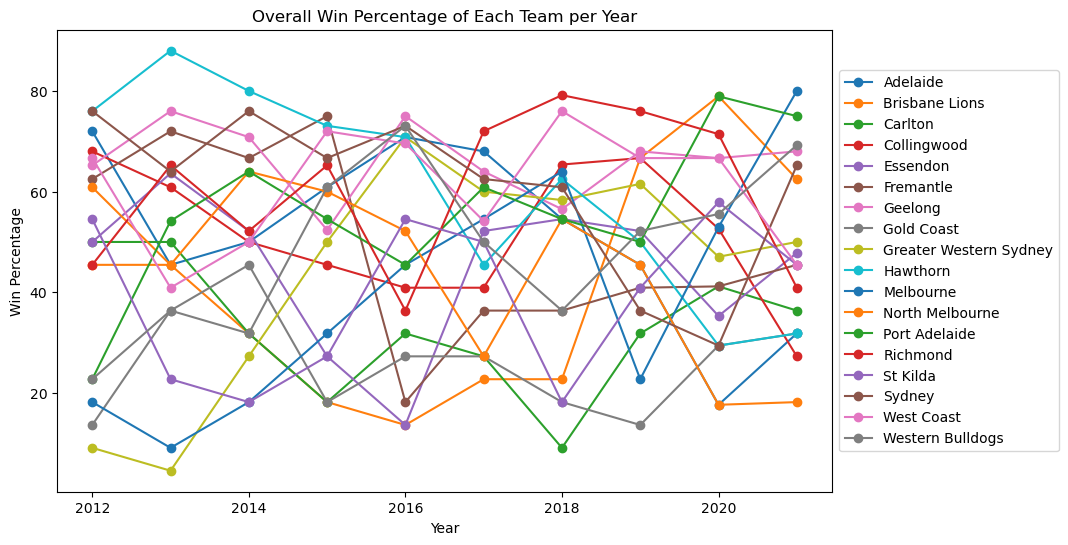

In [34]:
# Pivot the DataFrame to have teams as columns and years as rows
pivot_df = data_games_win.pivot(index='year', columns='team', values='win')

# Plotting the graph
pivot_df.plot(kind='line', marker='o', figsize=(10, 6))
plt.title('Overall Win Percentage of Each Team per Year')
plt.xlabel('Year')
plt.ylabel('Win Percentage')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

team
Adelaide                  51.662268
Brisbane Lions            40.811404
Carlton                   32.754011
Collingwood               51.809788
Essendon                  44.873285
Fremantle                 49.461586
Geelong                   66.262008
Gold Coast                26.122995
Greater Western Sydney    43.867304
Hawthorn                  60.709475
Melbourne                 39.694118
North Melbourne           44.559963
Port Adelaide             56.025633
Richmond                  60.393121
St Kilda                  38.971292
Sydney                    61.010595
West Coast                60.809552
Western Bulldogs          48.817945
Name: win, dtype: float64


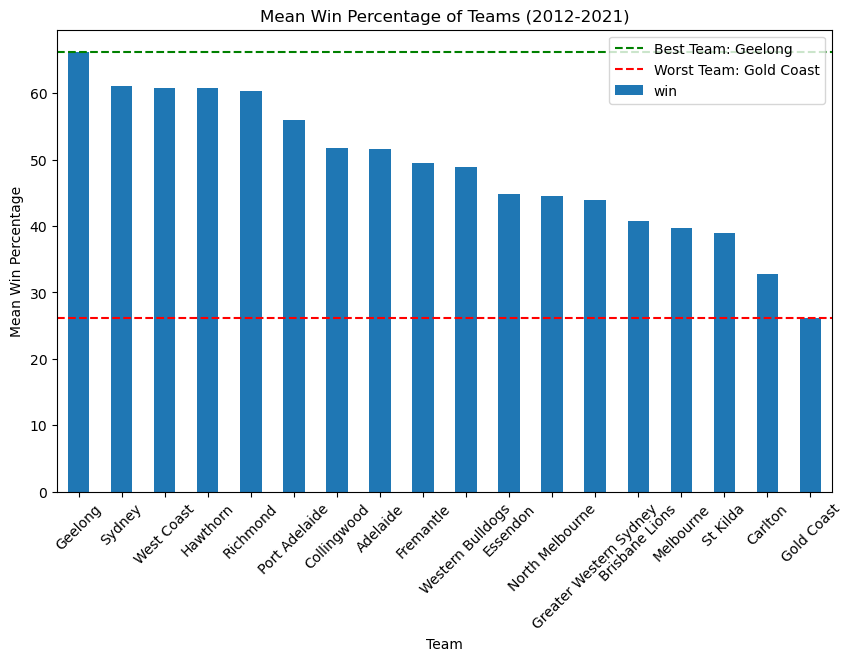

In [35]:
# Calculate the mean win percentage for each team
mean_win_percentage = data_games_win.groupby('team')['win'].mean()

# Print the mean win percentage for each team
print(mean_win_percentage)

# Sort the mean win percentages in descending order
mean_win_percentage_sorted = mean_win_percentage.sort_values(ascending=False)

# Get the best and worst teams
best_team = mean_win_percentage_sorted.index[0]
worst_team = mean_win_percentage_sorted.index[-1]

# Plotting the graph
mean_win_percentage_sorted.plot(kind='bar', figsize=(10, 6))
plt.title('Mean Win Percentage of Teams (2012-2021)')
plt.xlabel('Team')
plt.ylabel('Mean Win Percentage')
plt.xticks(rotation=45)
plt.axhline(y=mean_win_percentage[best_team], color='green', linestyle='--', label='Best Team: ' + best_team)
plt.axhline(y=mean_win_percentage[worst_team], color='red', linestyle='--', label='Worst Team: ' + worst_team)
plt.legend()
plt.show()

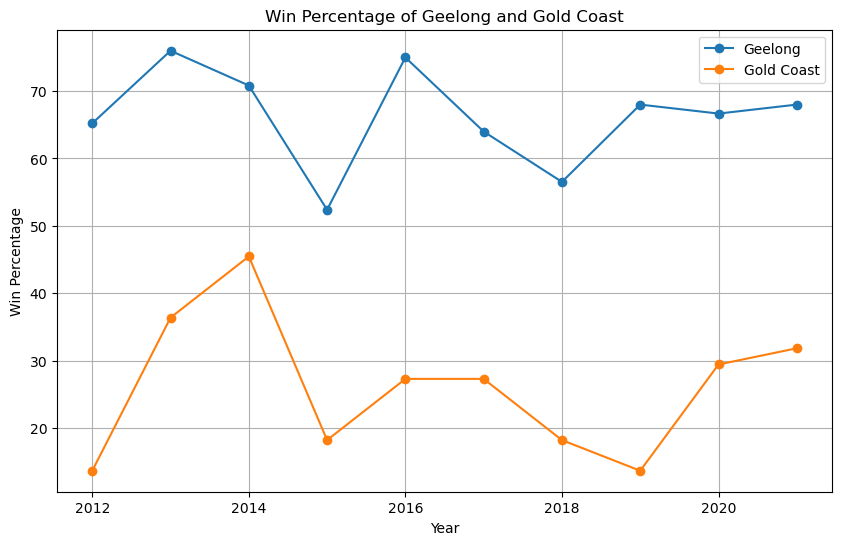

In [36]:
# Filter the DataFrame for Geelong and Gold Coast teams
geelong_data = data_games_win[data_games_win['team'] == 'Geelong']
gold_coast_data = data_games_win[data_games_win['team'] == 'Gold Coast']

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(geelong_data['year'], geelong_data['win'], marker='o', label='Geelong')
plt.plot(gold_coast_data['year'], gold_coast_data['win'], marker='o', label='Gold Coast')
plt.title('Win Percentage of Geelong and Gold Coast')
plt.xlabel('Year')
plt.ylabel('Win Percentage')
plt.legend()
plt.grid(True)
plt.show()

    index            team  year        win  win_change
0       0        Adelaide  2012  72.000000         NaN
1       1        Adelaide  2013  45.454545   -0.368687
2       2        Adelaide  2014  50.000000    0.100000
3       3        Adelaide  2015  60.869565    0.217391
4       4        Adelaide  2016  70.833333    0.163690
5       5        Adelaide  2017  68.000000   -0.040000
6       6        Adelaide  2018  54.545455   -0.197861
7       7        Adelaide  2019  45.454545   -0.166667
8       8        Adelaide  2020  17.647059   -0.611765
9       9        Adelaide  2021  31.818182    0.803030
10     10  Brisbane Lions  2012  45.454545         NaN
11     11  Brisbane Lions  2013  45.454545    0.000000
12     12  Brisbane Lions  2014  31.818182   -0.300000
13     13  Brisbane Lions  2015  18.181818   -0.428571
14     14  Brisbane Lions  2016  13.636364   -0.250000
15     15  Brisbane Lions  2017  22.727273    0.666667
16     16  Brisbane Lions  2018  22.727273    0.000000
17     17 

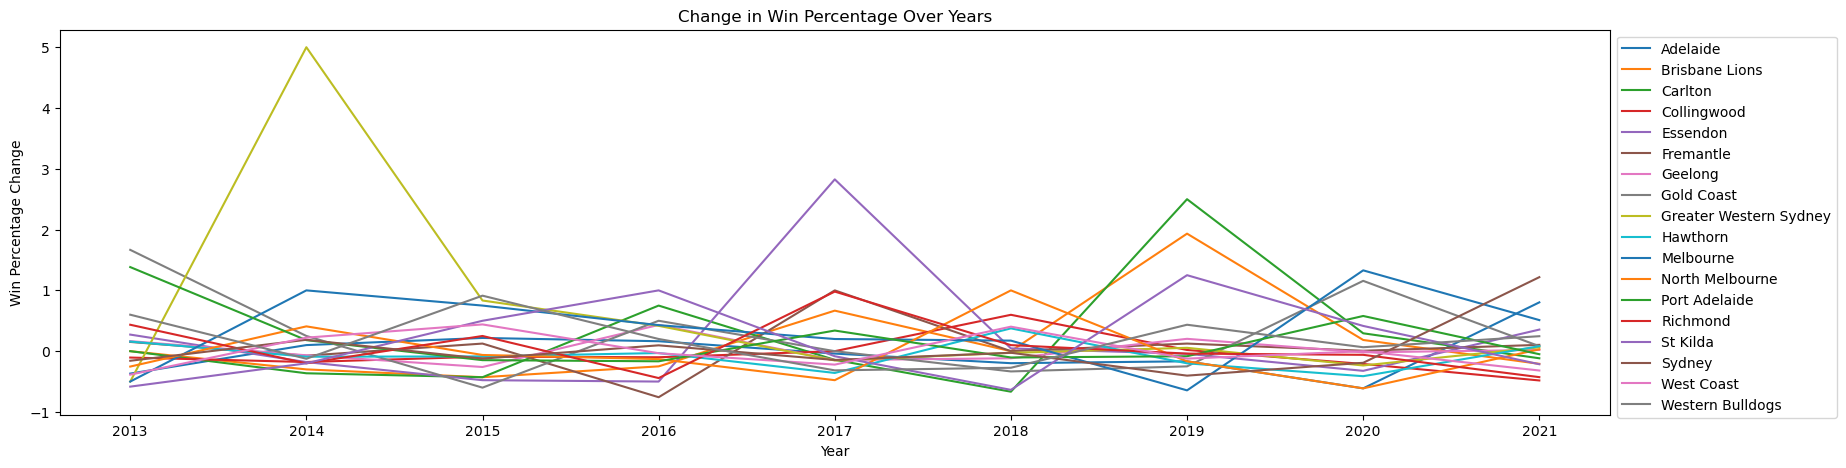

In [37]:
# Reset the index to access 'team' and 'year' as columns
data_games_win_reset = data_games_win.reset_index()

# Sort the dataframe by 'team' and 'year' in ascending order
data_games_win_reset = data_games_win_reset.sort_values(by=['team', 'year'])

# Calculate the change in win percentage using pct_change() method
data_games_win_reset['win_change'] = data_games_win_reset.groupby('team')['win'].pct_change()

# Print the resulting dataframe showing the change in win percentage for each team over all the years
print(data_games_win_reset.head(20))

# Groups the data by 'team' to plot each team's win percentage change separately.
grouped_data = data_games_win_reset.groupby('team')
plt.figure(figsize=(20, 5))

# Plotting the win percentage change for each team
for team, group in grouped_data:
    plt.plot(group['year'], group['win_change'], label=team)

# Labels the plot
plt.title("Change in Win Percentage Over Years")
plt.xlabel("Year")
plt.ylabel("Win Percentage Change")
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

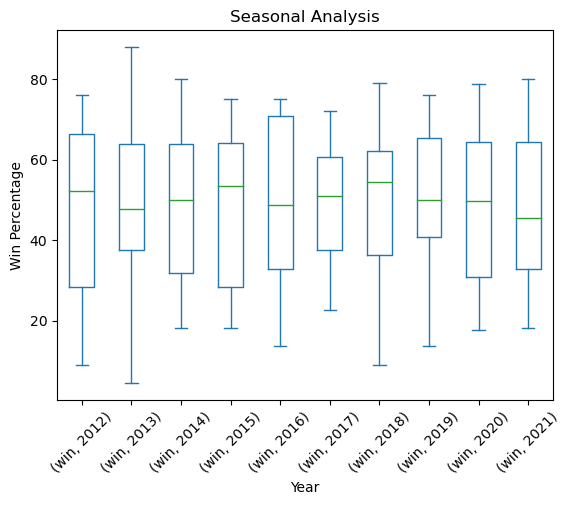

In [38]:
# Seasonal Analysis
data_games_win_seasonal = data_games_win.groupby(['team', 'year']).mean().unstack()
data_games_win_seasonal.plot(kind='box')
plt.xlabel('Year')
plt.ylabel('Win Percentage')
plt.title('Seasonal Analysis')
plt.xticks(rotation=45)
plt.show()

## Hypothesis testing (exploratory analysis)

In [39]:
### Overall grouped statistics
#--------------------------------

# Columns of interest.
cols = ['Disposals', 'Kicks', 'Marks', 'Handballs', 'Goals', 'Behinds', 'Hit Outs', 
        'Tackles', 'Rebounds', 'Inside 50s', 'Clearances', 'Clangers', 'Frees',
        'Frees Against', 'Contested Possessions', 'Uncontested Possessions', 
        'Contested Marks', 'Marks Inside 50', 'One Percenters', 'Bounces', 'Goal Assists']

# Splits data into two groups based on whether the year is before or after the pandemic.
before_covid = data[data['year'] < 2020]
after_covid = data[data['year'] >= 2020]
after_covid.loc[after_covid['year'] == 2020, cols]*=(20/16)

for col in cols:
    # Calculates the average value for each group before and after the pandemic.
    before_covid_mean = before_covid[col].mean()
    after_covid_mean = after_covid[col].mean()

    # Performs a two-sample t-test on the difference between means.
    t_statistic, p_value = ttest_ind(before_covid[col], after_covid[col], equal_var=False)

    # Check if p-value is significant at a = 0.01.
    if p_value < 0.01:
        significance = "significant"
    else:
        significance = "not significant"
    
    # Prints the results for each category.
    print(f"Column: {col}")
    print(f"Before Covid mean: {before_covid_mean:.2f}")
    print(f"After Covid mean: {after_covid_mean:.2f}")
    print(f"Difference: {after_covid_mean - before_covid_mean:.2f}")
    print(f"t-statistic: {t_statistic:.2f}")
    print(f"p-value: {p_value:.2g} ({significance})")
    print("")

Column: Disposals
Before Covid mean: 16.73
After Covid mean: 16.48
Difference: -0.25
t-statistic: 3.89
p-value: 9.9e-05 (significant)

Column: Kicks
Before Covid mean: 9.49
After Covid mean: 9.78
Difference: 0.29
t-statistic: -6.98
p-value: 3e-12 (significant)

Column: Marks
Before Covid mean: 4.08
After Covid mean: 4.11
Difference: 0.03
t-statistic: -1.27
p-value: 0.21 (not significant)

Column: Handballs
Before Covid mean: 7.24
After Covid mean: 6.69
Difference: -0.54
t-statistic: 14.24
p-value: 7.5e-46 (significant)

Column: Goals
Before Covid mean: 0.58
After Covid mean: 0.51
Difference: -0.07
t-statistic: 8.57
p-value: 1.1e-17 (significant)

Column: Behinds
Before Covid mean: 0.41
After Covid mean: 0.37
Difference: -0.04
t-statistic: 6.79
p-value: 1.1e-11 (significant)

Column: Hit Outs
Before Covid mean: 1.82
After Covid mean: 1.59
Difference: -0.22
t-statistic: 4.12
p-value: 3.9e-05 (significant)

Column: Tackles
Before Covid mean: 2.98
After Covid mean: 2.69
Difference: -0.29
t

C:\Users\User\AppData\Local\Temp\ipykernel_4548\1283756488.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after_covid.loc[after_covid['year'] == 2020, cols]*=(20/16)


In [40]:
### Team grouped statistics
#------------------------------

# Columns of interest.
cols = ['Disposals', 'Kicks', 'Marks', 'Handballs', 'Goals', 'Behinds', 'Hit Outs', 
        'Tackles', 'Rebounds', 'Inside 50s', 'Clearances', 'Clangers', 'Frees',
        'Frees Against', 'Contested Possessions', 'Uncontested Possessions', 
        'Contested Marks', 'Marks Inside 50', 'One Percenters', 'Bounces', 'Goal Assists', 'win']
teams = pd.Series(data['team'].drop_duplicates().values)

# Splits data into two groups based on whether the year is before or after the pandemic.
before_covid = data_games[data_games['year'] < 2020]
after_covid = data_games[data_games['year'] >= 2020]
after_covid.loc[after_covid['year'] == 2020, cols]*=(20/16)

for col in cols:
    for team in teams:
        # Calculates the average value for each group before and after the pandemic.
        before_covid_mean = before_covid[before_covid['team'] == team][col].mean()
        after_covid_mean = after_covid[after_covid['team'] == team][col].mean()
    
        # Performs a two-sample t-test on the difference between means.
        t_statistic, p_value = ttest_ind(
            before_covid[before_covid['team'] == team][col],
            after_covid[after_covid['team'] == team][col],
            equal_var=False,
        )

        # Checks if the p-value for each metric is significant at a = 0.02.
        if p_value < 0.02:
            significance = "significant"
        else:
            significance = "not significant"

        # Prints the results for each category, as long as it is significant.
        if significance == "significant":
            print("Team: " + team)
            print("Column: " + col)
            print("Before Covid mean: " + str(before_covid_mean))
            print("After Covid mean: " + str(after_covid_mean))
            print("Difference: " + str(after_covid_mean - before_covid_mean))
            print("t-statistic: " + str(t_statistic))
            print("p-value: " + str(p_value) + " (" + str(significance) + ")")
            print("")


C:\Users\User\AppData\Local\Temp\ipykernel_4548\2070872381.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after_covid.loc[after_covid['year'] == 2020, cols]*=(20/16)


Team: Adelaide
Column: Disposals
Before Covid mean: 375.5243243243243
After Covid mean: 353.39102564102564
Difference: -22.133298683298676
t-statistic: 3.57550449591507
p-value: 0.000701588521019269 (significant)

Team: Geelong
Column: Disposals
Before Covid mean: 370.61052631578946
After Covid mean: 384.42391304347825
Difference: 13.813386727688794
t-statistic: -2.4774265064949197
p-value: 0.015720016561221604 (significant)

Team: Port Adelaide
Column: Disposals
Before Covid mean: 368.61538461538464
After Covid mean: 383.9360465116279
Difference: 15.32066189624328
t-statistic: -2.4304281798364076
p-value: 0.017995655217441967 (significant)

Team: Adelaide
Column: Kicks
Before Covid mean: 217.63243243243244
After Covid mean: 201.82692307692307
Difference: -15.805509355509372
t-statistic: 4.6613609366941695
p-value: 1.8854226123209112e-05 (significant)

Team: Geelong
Column: Kicks
Before Covid mean: 206.8842105263158
After Covid mean: 229.7608695652174
Difference: 22.876659038901607
t-s

Team: Geelong
Column: Tackles
Before Covid mean: 69.27368421052631
After Covid mean: 60.32608695652174
Difference: -8.94759725400457
t-statistic: 4.149568387695617
p-value: 8.636865273619493e-05 (significant)

Team: Sydney
Column: Tackles
Before Covid mean: 71.15463917525773
After Covid mean: 64.125
Difference: -7.029639175257728
t-statistic: 2.8935858313905967
p-value: 0.005262182935774823 (significant)

Team: North Melbourne
Column: Tackles
Before Covid mean: 62.72826086956522
After Covid mean: 56.73717948717949
Difference: -5.99108138238573
t-statistic: 2.8958142114301784
p-value: 0.005227837592039021 (significant)

Team: Fremantle
Column: Tackles
Before Covid mean: 64.83783783783784
After Covid mean: 54.12820512820513
Difference: -10.709632709632707
t-statistic: 4.536033510383425
p-value: 3.337936053803317e-05 (significant)

Team: West Coast
Column: Tackles
Before Covid mean: 63.5026455026455
After Covid mean: 52.375
Difference: -11.1276455026455
t-statistic: 5.863950327757166
p-va

Team: Essendon
Column: Clangers
Before Covid mean: 49.726256983240226
After Covid mean: 57.5125
Difference: 7.7862430167597765
t-statistic: -4.309433466069742
p-value: 7.320524221433325e-05 (significant)

Team: Hawthorn
Column: Clangers
Before Covid mean: 47.056994818652846
After Covid mean: 56.12179487179487
Difference: 9.064800053142022
t-statistic: -4.91345083050791
p-value: 1.0667321886875476e-05 (significant)

Team: Western Bulldogs
Column: Clangers
Before Covid mean: 46.637362637362635
After Covid mean: 52.75
Difference: 6.112637362637365
t-statistic: -3.8579252423592703
p-value: 0.0002831858825186483 (significant)

Team: Collingwood
Column: Clangers
Before Covid mean: 49.31182795698925
After Covid mean: 57.84146341463415
Difference: 8.5296354576449
t-statistic: -5.322350595872102
p-value: 1.931994388457199e-06 (significant)

Team: Adelaide
Column: Frees
Before Covid mean: 18.291891891891893
After Covid mean: 21.506410256410255
Difference: 3.214518364518362
t-statistic: -3.331053

Team: Port Adelaide
Column: win
Before Covid mean: 0.510989010989011
After Covid mean: 0.8546511627906976
Difference: 0.3436621518016867
t-statistic: -4.127126993671649
p-value: 0.00010738400565107072 (significant)

Team: Melbourne
Column: win
Before Covid mean: 0.33519553072625696
After Covid mean: 0.7440476190476191
Difference: 0.4088520883213621
t-statistic: -4.711578725949227
p-value: 1.561500198715188e-05 (significant)

Team: Brisbane Lions
Column: win
Before Covid mean: 0.33707865168539325
After Covid mean: 0.7848837209302325
Difference: 0.44780506924483926
t-statistic: -5.045226731912474
p-value: 4.613396994092679e-06 (significant)

Team: Hawthorn
Column: win
Before Covid mean: 0.689119170984456
After Covid mean: 0.33974358974358976
Difference: -0.3493755812408662
t-statistic: 3.888383472007725
p-value: 0.0002933942605916066 (significant)

Team: Western Bulldogs
Column: win
Before Covid mean: 0.46153846153846156
After Covid mean: 0.6931818181818182
Difference: 0.2316433566433566

.